In [ ]:
# !pip install lime

In [ ]:
import lime
import nltk
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from sklearn import preprocessing
from matplotlib   import cm
from nltk.corpus  import stopwords
from wordcloud    import WordCloud
from keras.utils  import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Input
from keras.models import Model

from lime.lime_text import LimeTextExplainer
from tensorflow.keras  import layers
from keras.callbacks   import ModelCheckpoint, EarlyStopping
from sklearn.metrics   import classification_report
from sklearn.metrics   import roc_curve, auc, confusion_matrix
from sklearn.metrics   import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras  import backend as K
from matplotlib.colors import Normalize, Colormap, LinearSegmentedColormap
from sklearn.model_selection  import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Input tokenized and padded

In [ ]:
# Load your data
df = pd.read_csv('/content/drive/MyDrive/clean_data.csv')
# df = pd.read_csv('clean_data.csv')

sentences = df['headline'].tolist()
labels = df['is_sarcastic'].tolist()

# Split the data into training and test sets
sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences,
                                                                              labels,
                                                                              test_size=0.2,
                                                                              random_state=2456)

# Tokenization and padding
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences_train)
word_index = tokenizer.word_index
# print(word_index)

# Define a fixed sequence length
max_sequence_length_train = 30

# Pad sequences for both training and test sets
seq_train = tokenizer.texts_to_sequences(sentences_train)
seq_test  = tokenizer.texts_to_sequences(sentences_test)
# print(seq_test)
# print("---")

padded_seq_train = pad_sequences(seq_train, padding="post",
                                 maxlen=max_sequence_length_train)
padded_seq_test  = pad_sequences(seq_test, padding="post",
                                 maxlen=max_sequence_length_train)
# print(padded_seq_test)
# print("---")

# Convert labels to numpy arrays for both training and test sets
labels_train = np.array(labels_train)
labels_test  = np.array(labels_test)

# print(labels_test)

In [ ]:
lemmatizer = nltk.wordnet.WordNetLemmatizer()
lemma = lemmatizer.lemmatize

# generate wordclouds
group_list = df.is_sarcastic.unique()
cloud_list = []

colors = ["#7CCDFF","#01D38E","#EC4C36","#35A2A1","#FFBD0B"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

for idx, i in enumerate(group_list):
    text   = ' '.join(df.headline[df.is_sarcastic.isin([i])])
    tokens = nltk.word_tokenize(text)
    lemmatized = [lemma(token) for token in tokens]
    lemmatized = ' '.join(lemmatized)

    wordcloud = WordCloud(max_font_size=160, max_words=70,
                          width=1600, height=800,
                          scale=3, colormap=cmap,
                          min_font_size=10,
                          min_word_length=3,
                          normalize_plurals=True,
                          stopwords=stopwords.words('english'),
                          background_color="white").generate(lemmatized)
    cloud_list.append(wordcloud)

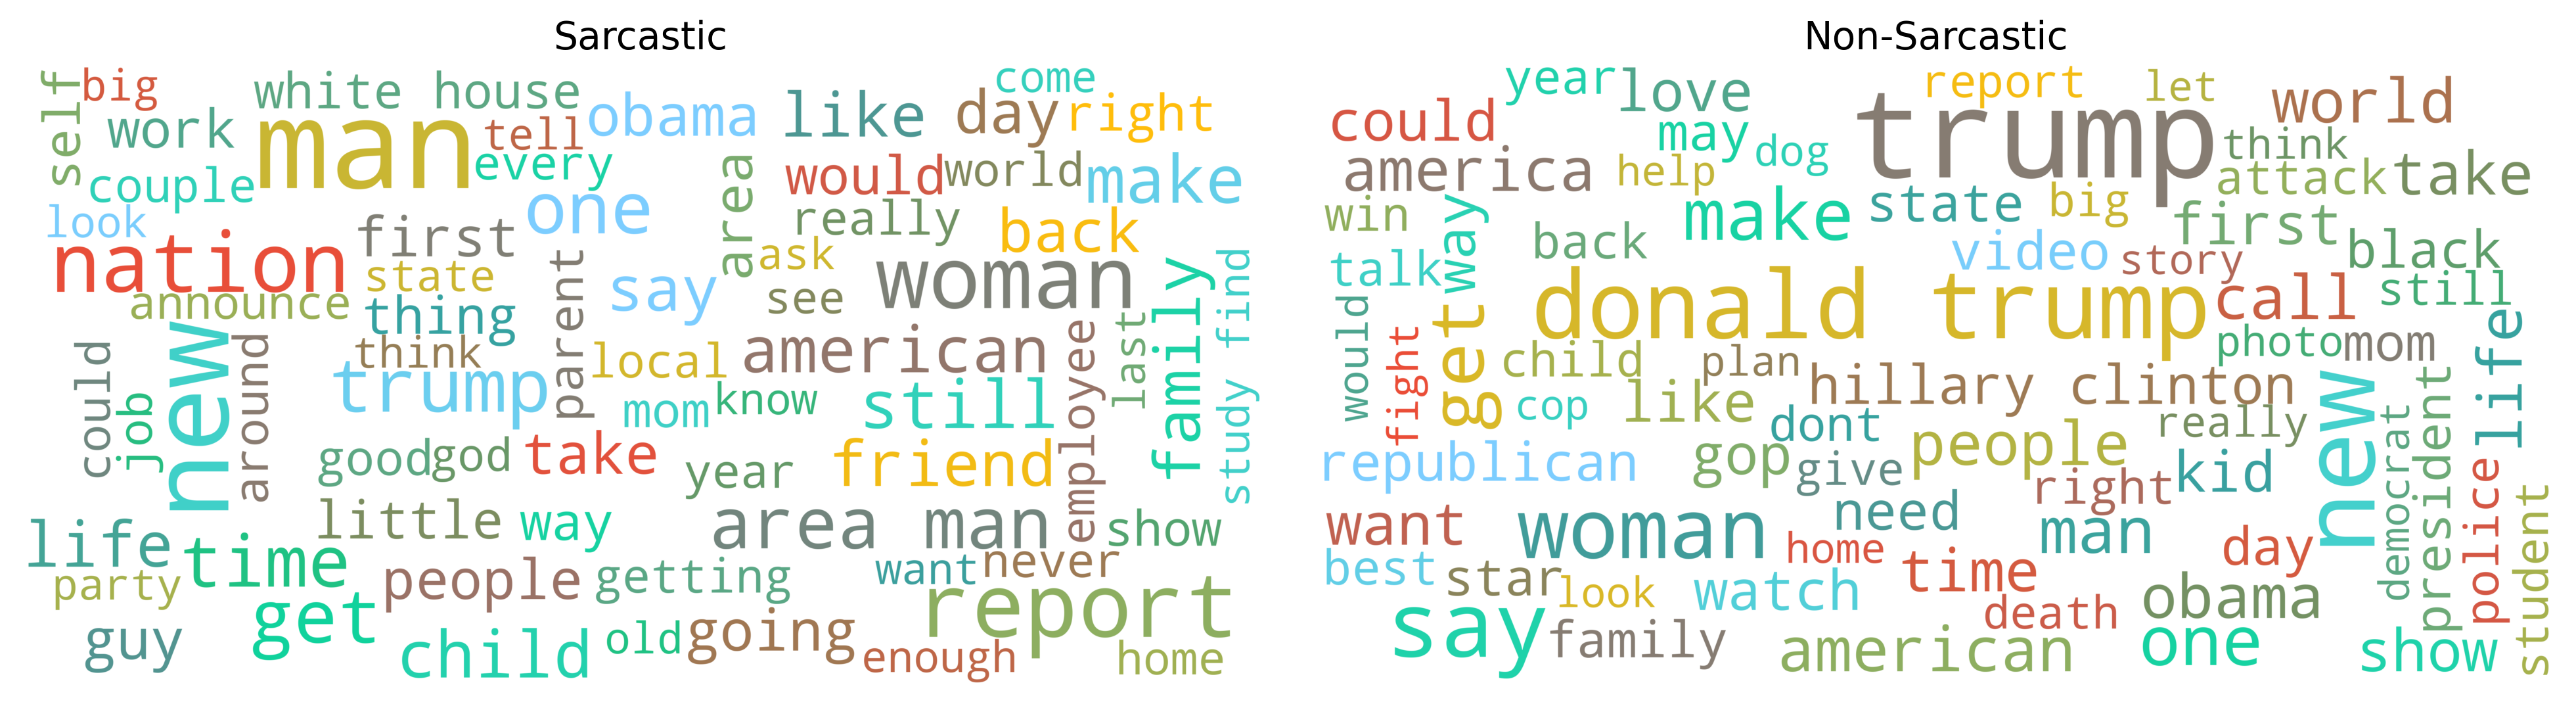

In [ ]:
# plotting
fig = plt.figure(figsize=(20, 16), dpi=300)
plt.subplots_adjust(hspace=0.5)
for idx, cloud in enumerate(cloud_list):
    ax = plt.subplot(4, 3, idx+1)
    ax.imshow(cloud, interpolation="bilinear")
    ax.set_axis_off()
    ax.set_title("Sarcastic" if idx == 0 else "Non-Sarcastic", size=14)

plt.tight_layout(pad=2.)
plt.show()

## Baseline: Logistic Regression

In [ ]:
ngram_range=(1, 1)
vectorizer = TfidfVectorizer(ngram_range=ngram_range)
X = vectorizer.fit_transform(sentences)
tfidf_matrix = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())

# normalization
X = preprocessing.normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, labels,
                                                    train_size = 0.8,
                                                    test_size=0.2,
                                                    random_state=2456)


Accuracy:    0.821626
Precision:   0.809281
Recall:      0.817986
F1 Score:    0.813610


Confusion Matrix: 



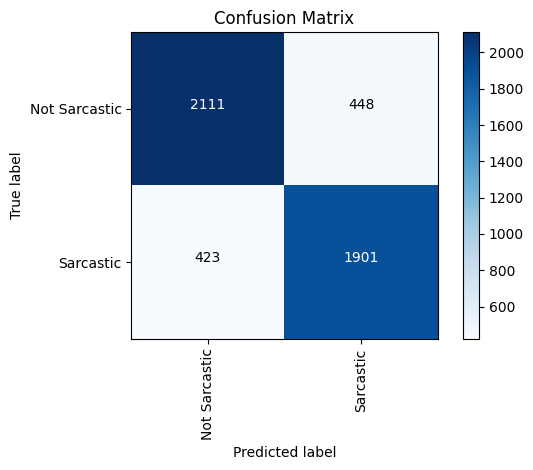

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# helper function to print accuracy, precision, recall, F1
def print_4_metrics(target_test, predicted):
  print("%-12s %f" % ('Accuracy:', accuracy_score(target_test,predicted)))
  print("%-12s %f" % ('Precision:', precision_score(target_test, predicted,labels=None,
                                                    pos_label=1, average='binary', sample_weight=None)))
  print("%-12s %f" % ('Recall:', recall_score(target_test, predicted,labels=None,
                                              pos_label=1, average='binary', sample_weight=None)))
  print("%-12s %f" % ('F1 Score:', f1_score(target_test, predicted,labels=None,
                                            pos_label=1, average='binary', sample_weight=None)))

# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)
log_predicted = log_reg.predict(X_test)
log_score = log_reg.predict_proba(X_test)[:,1]

print_4_metrics(y_test, log_predicted)

print("\n\nConfusion Matrix: \n")
draw_confusion_matrix(y_test, log_predicted, ['Not Sarcastic', 'Sarcastic'])

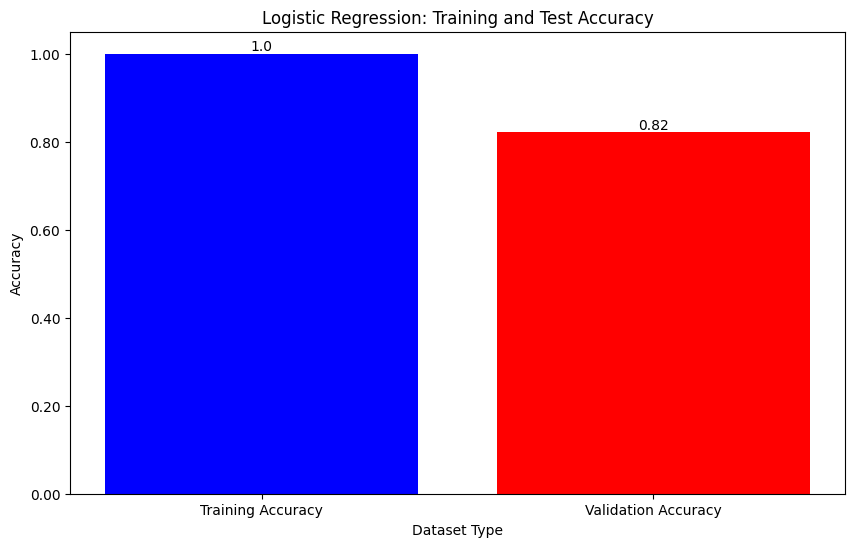

In [ ]:
# predcit on training set and test set
y_train_pred = log_reg.predict(X_train)

# get accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, log_predicted)

# draw accuracy graph
plt.figure(figsize=(10, 6), dpi=100)
bars = plt.bar(['Training Accuracy', 'Validation Accuracy'],
               [train_accuracy, test_accuracy], color=['blue', 'red'])
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy")
plt.title('Logistic Regression: Training and Test Accuracy')
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval,
             round(yval, 2), ha='center', va='bottom')
plt.show()

## Model: LSTM + Attention

In [ ]:
class AttentionLayers(tf.keras.layers.Layer):
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayers, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        super(AttentionLayers, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.dot(x, self.W), axis=-1)
        at = tf.keras.backend.exp(et)
        at_sum = tf.keras.backend.sum(at, axis=1, keepdims=True)
        at = at / at_sum
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x * at
        if self.return_attention:
            return [tf.keras.backend.sum(output, axis=1), at]
        else:
            return tf.keras.backend.sum(output, axis=1)


# Define the model with attention mechanism
input_layer = Input(shape=(max_sequence_length_train,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=64,
                            input_length=max_sequence_length_train)(input_layer)
lstm_layer = LSTM(64, return_sequences=True)(embedding_layer)
attention_output, attention_weights = AttentionLayers(return_attention=True)(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(attention_output)
attention_model = Model(inputs=input_layer, outputs=[output_layer, attention_weights])

# Compile and train the model with attention mechanism
attention_model.compile(loss='binary_crossentropy', optimizer='adam',
                        metrics=['accuracy'])
attention_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 64)            1454784   
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 attention_layers (Attentio  [(None, 64),              64        
 nLayers)                     (None, 30, 1)]                     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1487937 (5.68 MB)
Trainable params: 1487937 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [ ]:
history_2 = attention_model.fit(padded_seq_train, labels_train,
                                epochs = 5,
                                validation_data = (padded_seq_test, labels_test))

Epoch 1/5
611/611 [==============================] - 38s 38ms/step - loss: 2.0592 - dense_loss: 0.4117 - attention_layers_loss: 1.6475 - dense_accuracy: 0.8065 - attention_layers_accuracy: 0.5208 - val_loss: 1.9886 - val_dense_loss: 0.3520 - val_attention_layers_loss: 1.6366 - val_dense_accuracy: 0.8540 - val_attention_layers_accuracy: 0.5241
Epoch 2/5
611/611 [==============================] - 6s 10ms/step - loss: 1.8470 - dense_loss: 0.1995 - attention_layers_loss: 1.6475 - dense_accuracy: 0.9241 - attention_layers_accuracy: 0.5208 - val_loss: 2.0210 - val_dense_loss: 0.3844 - val_attention_layers_loss: 1.6365 - val_dense_accuracy: 0.8466 - val_attention_layers_accuracy: 0.5241
Epoch 3/5
611/611 [==============================] - 5s 8ms/step - loss: 1.7580 - dense_loss: 0.1105 - attention_layers_loss: 1.6475 - dense_accuracy: 0.9614 - attention_layers_accuracy: 0.5208 - val_loss: 2.0882 - val_dense_loss: 0.4515 - val_attention_layers_loss: 1.6367 - val_dense_accuracy: 0.8423 - val_at

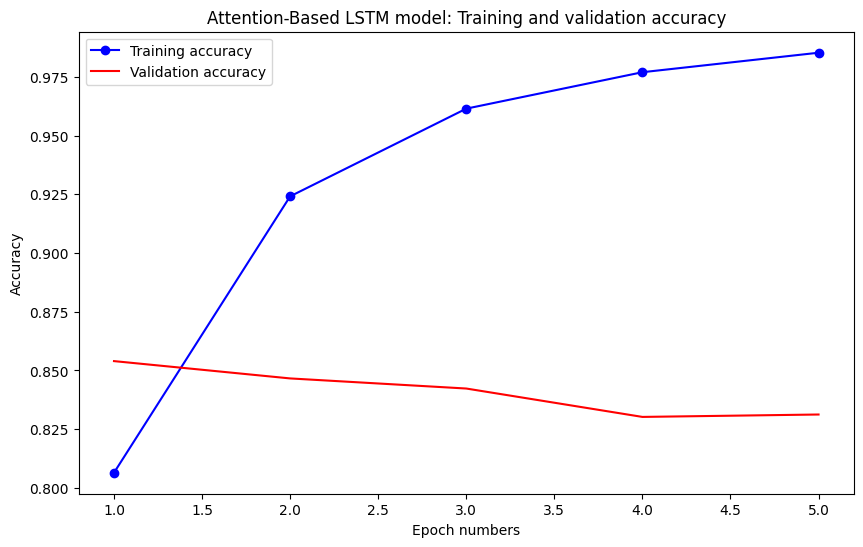

In [ ]:
plt.figure(figsize=(10, 6), dpi=100)
acc = history_2.history['dense_accuracy']
val_acc = history_2.history['val_dense_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel("Epoch numbers")
plt.ylabel("Accuracy")
plt.title('Attention-Based LSTM model: Training and validation accuracy')
plt.legend()
plt.show()

153/153 [==============================] - 1s 2ms/step


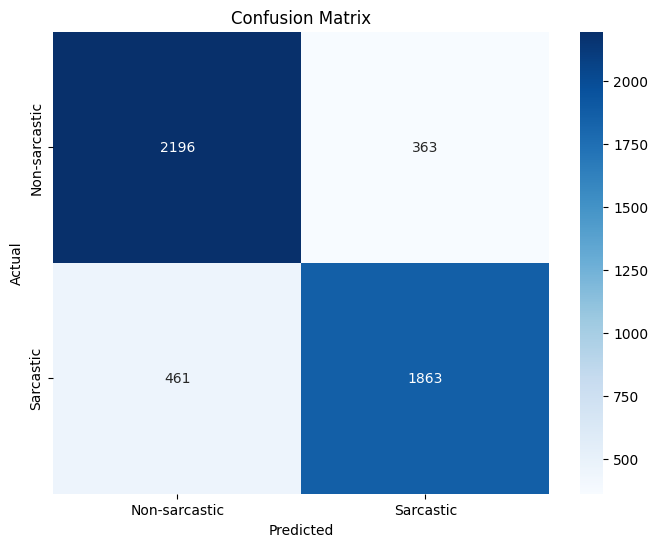

In [ ]:
prob   = attention_model.predict(padded_seq_test)[0]
y_pred = (prob > 0.5).astype("int32")

cm = confusion_matrix(labels_test, y_pred)

# Plotting
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-sarcastic', 'Sarcastic'],
            yticklabels=['Non-sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 18ms/step
[[0.9955071]]


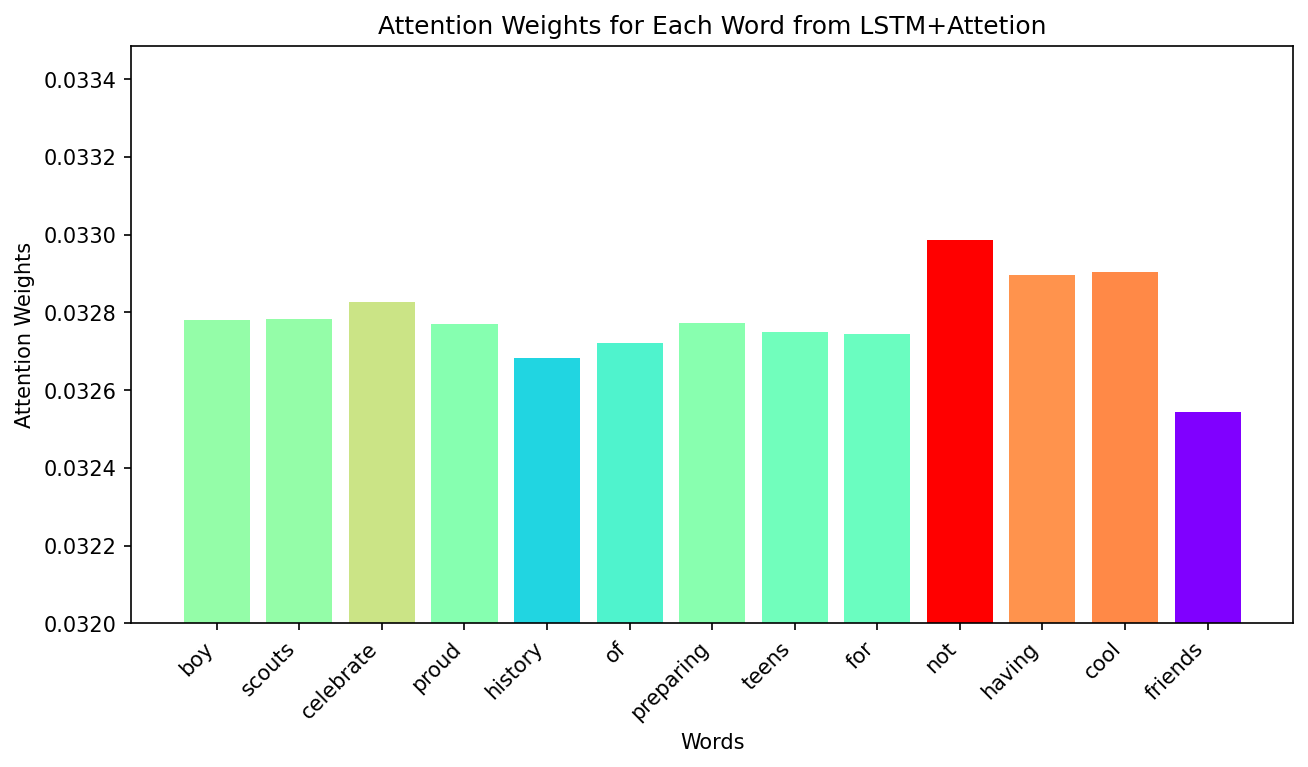

In [ ]:
def visualize_attention_weights(sentence, model, tokenizer):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, padding="post",
                                    maxlen=max_sequence_length_train)

    # get the attention weights
    prediction, attention_weights = model.predict(padded_sequence)
    print(prediction)

    # handle the example
    words = sentence.split()
    num_words = len(words)

    # trim the length
    attention_weights = attention_weights[0, :num_words].reshape(-1)

    # normalize the attention weights to range [0, 1] for color mapping
    attention_weights_log = np.log(attention_weights + 1e-5)
    normalized_weights_log = (attention_weights_log - np.min(attention_weights_log)) / (np.max(attention_weights_log) - np.min(attention_weights_log))
    cols = plt.cm.rainbow(normalized_weights_log)

    # plot
    plt.figure(figsize=(10, 5),dpi=150)
    plt.bar(np.arange(num_words), attention_weights, color=cols)
    plt.xticks(np.arange(num_words), words, rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Attention Weights')
    plt.ylim(0.032, max(attention_weights) + 0.0005)
    plt.title('Attention Weights for Each Word from LSTM+Attetion')
    plt.show()

example_1 = "boy scouts celebrate proud history of preparing teens for not having cool friends"
visualize_attention_weights(example_1, attention_model, tokenizer)

1/1 [==============================] - 0s 18ms/step
[[0.04356665]]


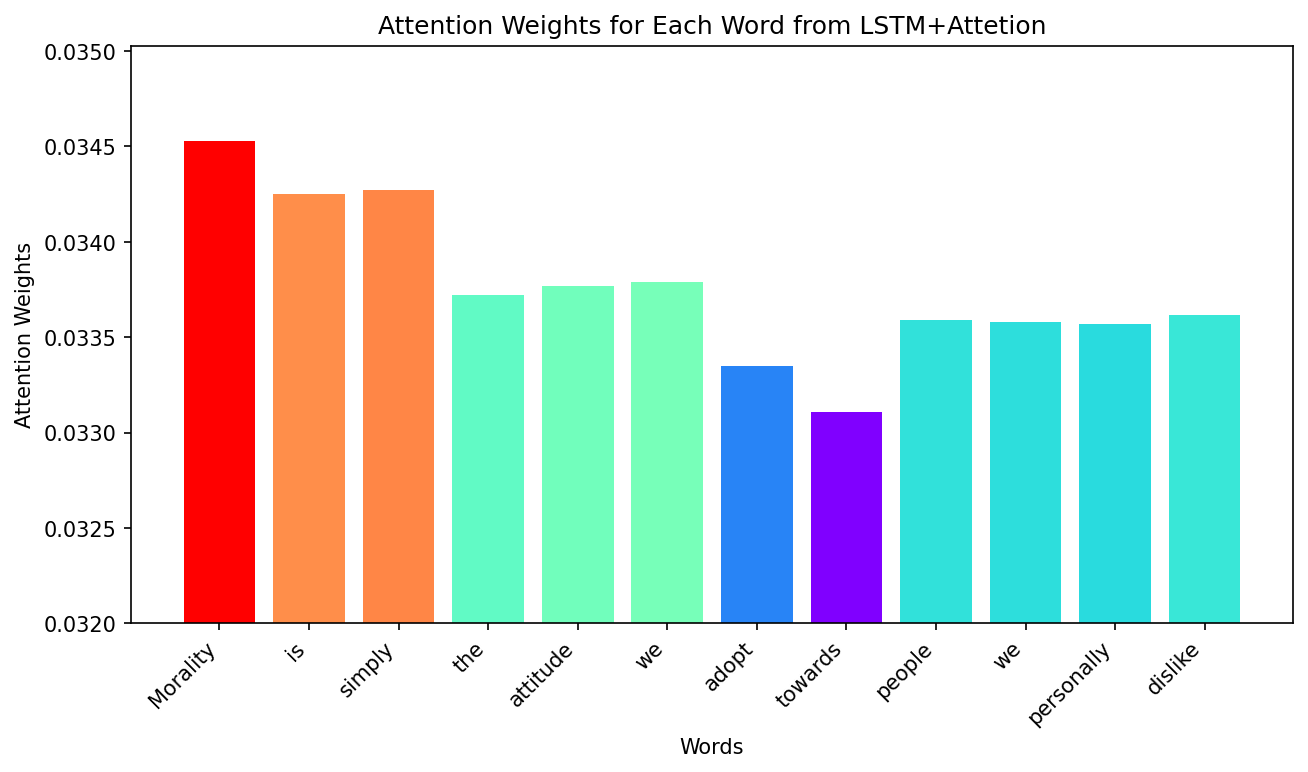

In [ ]:
example_2 = "Morality is simply the attitude we adopt towards people we personally dislike"
visualize_attention_weights(example_2, attention_model, tokenizer)

1/1 [==============================] - 0s 22ms/step
[[0.00112915]]


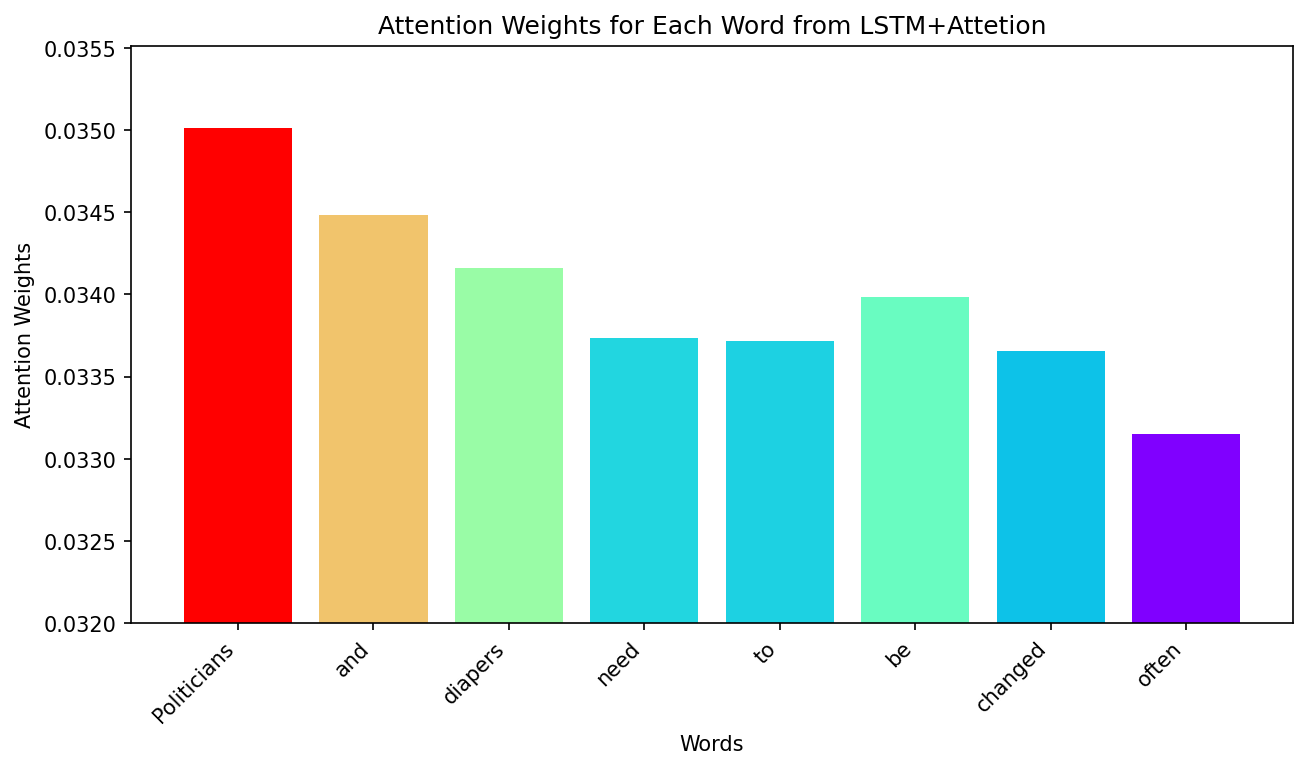

In [ ]:
example_3 = "Politicians and diapers need to be changed often"
visualize_attention_weights(example_3, attention_model, tokenizer)

## Model: CNN+Bi-LSTM+Attention

In [ ]:
class AttentionLayer_2(tf.keras.layers.Layer):
    """
    Keras layer to compute an attention score for each input sequence.
    """
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer_2, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1, 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer_2, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_attention:
            return [K.sum(output, axis=1), a]
        return K.sum(output, axis=1)


class ConvNet(tf.keras.layers.Layer):
    def __init__(self, filter_h, out_channels):
        super(ConvNet, self).__init__()
        self.conv1d = tf.keras.layers.Conv1D(out_channels, kernel_size=filter_h,
                                             activation='relu', padding='same')

    def call(self, x):
        x = self.conv1d(x)
        return x

input_layer = Input(shape=(max_sequence_length_train,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=100,
                            input_length=max_sequence_length_train)(input_layer)
cnn_layer = ConvNet(5, 64)(embedding_layer)
bilstm_layer = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True))(cnn_layer)
attention_output = AttentionLayer_2(return_attention=False)(bilstm_layer)
output_layer = Dense(1, activation='sigmoid')(attention_output)

hybrid_model = Model(inputs=input_layer, outputs=output_layer)
hybrid_model.compile(loss='binary_crossentropy', optimizer='adam',
                     metrics=['accuracy'])
hybrid_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 100)           2273100   
                                                                 
 conv_net (ConvNet)          (None, 30, 64)            32064     
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           66048     
 al)                                                             
                                                                 
 attention_layer_2 (Attenti  (None, 128)               129       
 onLayer_2)                                                      
                                                                 
 dense_1 (Dense)             (None, 1)                 129 

In [ ]:
history_3 = hybrid_model.fit(padded_seq_train, labels_train,
                             epochs = 5,
                             validation_data = (padded_seq_test, labels_test))

Epoch 1/5
611/611 [==============================] - 32s 33ms/step - loss: 0.4120 - accuracy: 0.8047 - val_loss: 0.3287 - val_accuracy: 0.8560
Epoch 2/5
611/611 [==============================] - 11s 18ms/step - loss: 0.1651 - accuracy: 0.9394 - val_loss: 0.3503 - val_accuracy: 0.8552
Epoch 3/5
611/611 [==============================] - 13s 21ms/step - loss: 0.0575 - accuracy: 0.9810 - val_loss: 0.4716 - val_accuracy: 0.8482
Epoch 4/5
611/611 [==============================] - 8s 13ms/step - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.6627 - val_accuracy: 0.8450
Epoch 5/5
611/611 [==============================] - 8s 12ms/step - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.8255 - val_accuracy: 0.8444


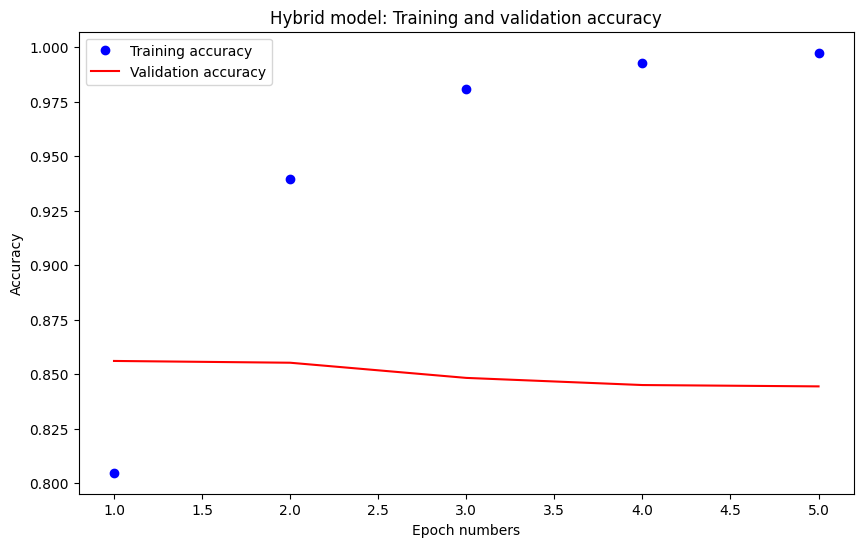

In [ ]:
plt.figure(figsize=(10, 6), dpi=100)
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.legend()
plt.xlabel("Epoch numbers")
plt.ylabel("Accuracy")
plt.title('Hybrid model: Training and validation accuracy')
plt.savefig('Hybrid_acc_plot.png')
plt.show()

153/153 [==============================] - 1s 3ms/step


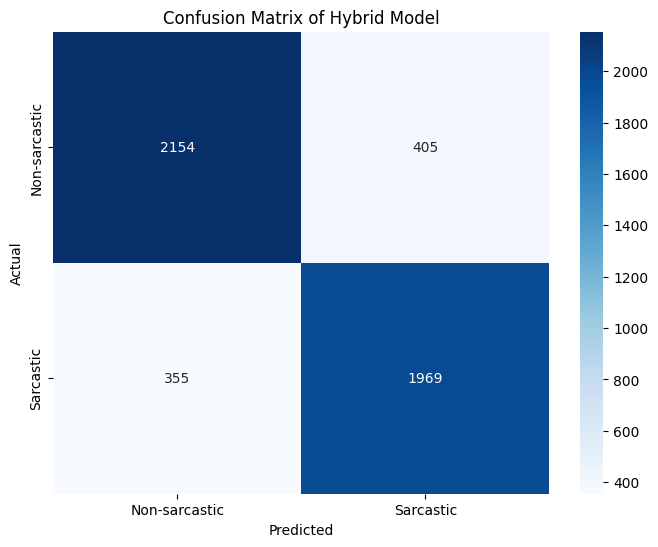

In [ ]:
prob   = hybrid_model.predict(padded_seq_test)
y_pred = (prob > 0.5).astype("int32")
cm = confusion_matrix(labels_test, y_pred)

# Plotting
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-sarcastic', 'Sarcastic'],
            yticklabels=['Non-sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix of Hybrid Model')
plt.show()

1/1 [==============================] - 1s 703ms/step
[[0.9999993]]


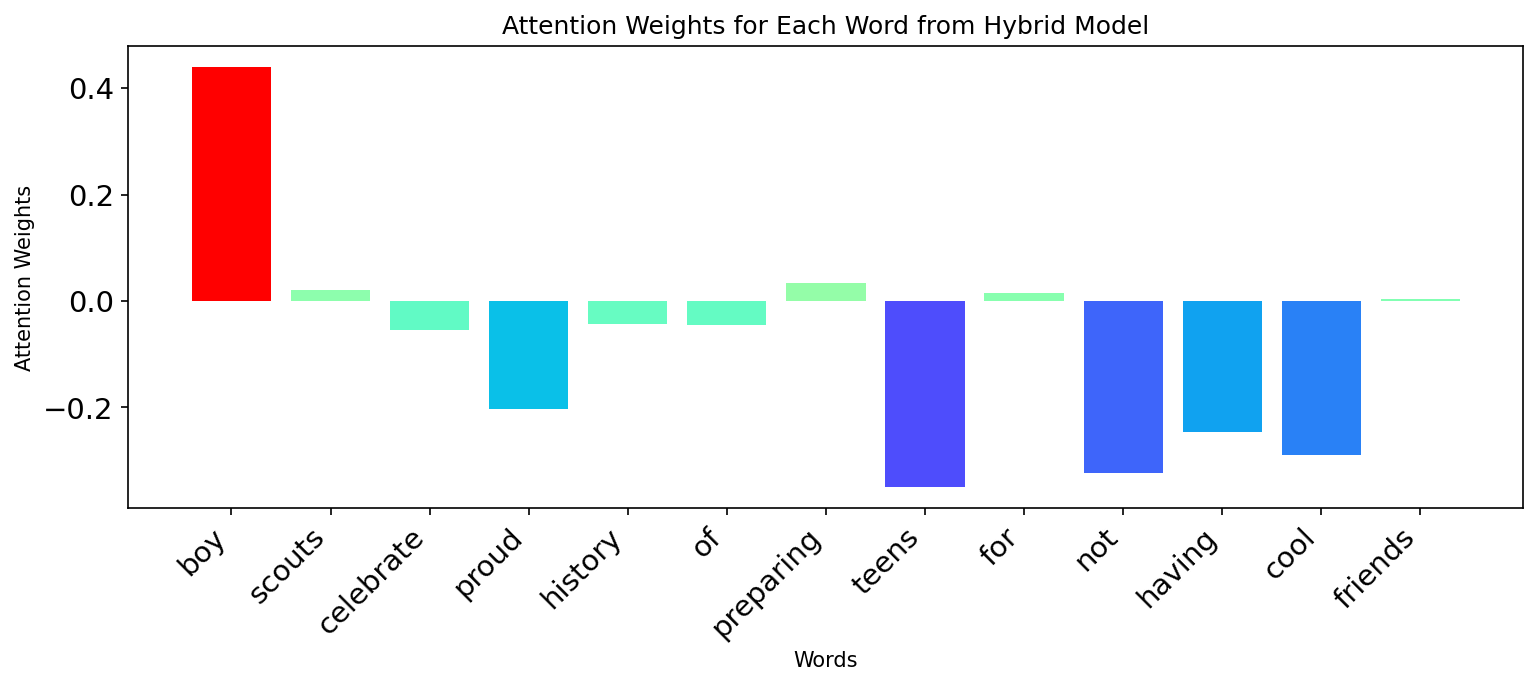

In [ ]:
# import again avoiding error
from matplotlib  import cm

def visualize_attention_weights(sentence, model, tokenizer):
    # Tokenize and pad the input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, padding="post",
                                    maxlen=max_sequence_length_train)

    # Define a submodel to extract the output from attention layer with weights
    # Replace with the correct name from the summary, if u've run it many times
    attention_layer = model.get_layer('attention_layer_2')
    submodel = Model(inputs=model.input, outputs=[model.output, attention_layer.output])

    # Get the prediction and attention weights
    prediction, attention_weights = submodel.predict(padded_sequence)
    print(prediction)

    # The attention_weights might have an extra dimension because of the batch size
    # even if it's just one sentence
    attention_weights = np.squeeze(attention_weights)

    # trim the weight array
    actual_length = len(sequence[0])
    trimmed_attention_weights = attention_weights[:actual_length]

    # Extract the words corresponding to the tokens for visualization
    words = [tokenizer.index_word.get(token) for token in sequence[0]]

    # Normalize the attention weights for color mapping
    max_weight = max(abs(trimmed_attention_weights.min()), trimmed_attention_weights.max())
    normalized_weights = trimmed_attention_weights / max_weight
    cols = plt.cm.rainbow((normalized_weights + 1) / 2)

    # Plot the attention weights
    plt.figure(figsize=(12, 4), dpi=150)
    plt.bar(range(len(words)), trimmed_attention_weights, color=cols)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.tick_params(axis='x', which='major', labelsize=14)
    plt.xlabel('Words')
    plt.ylabel('Attention Weights')
    plt.title('Attention Weights for Each Word from Hybrid Model')
    plt.show()

# Example usage
visualize_attention_weights(example_1, hybrid_model, tokenizer)

1/1 [==============================] - 1s 671ms/step
[[0.00048933]]


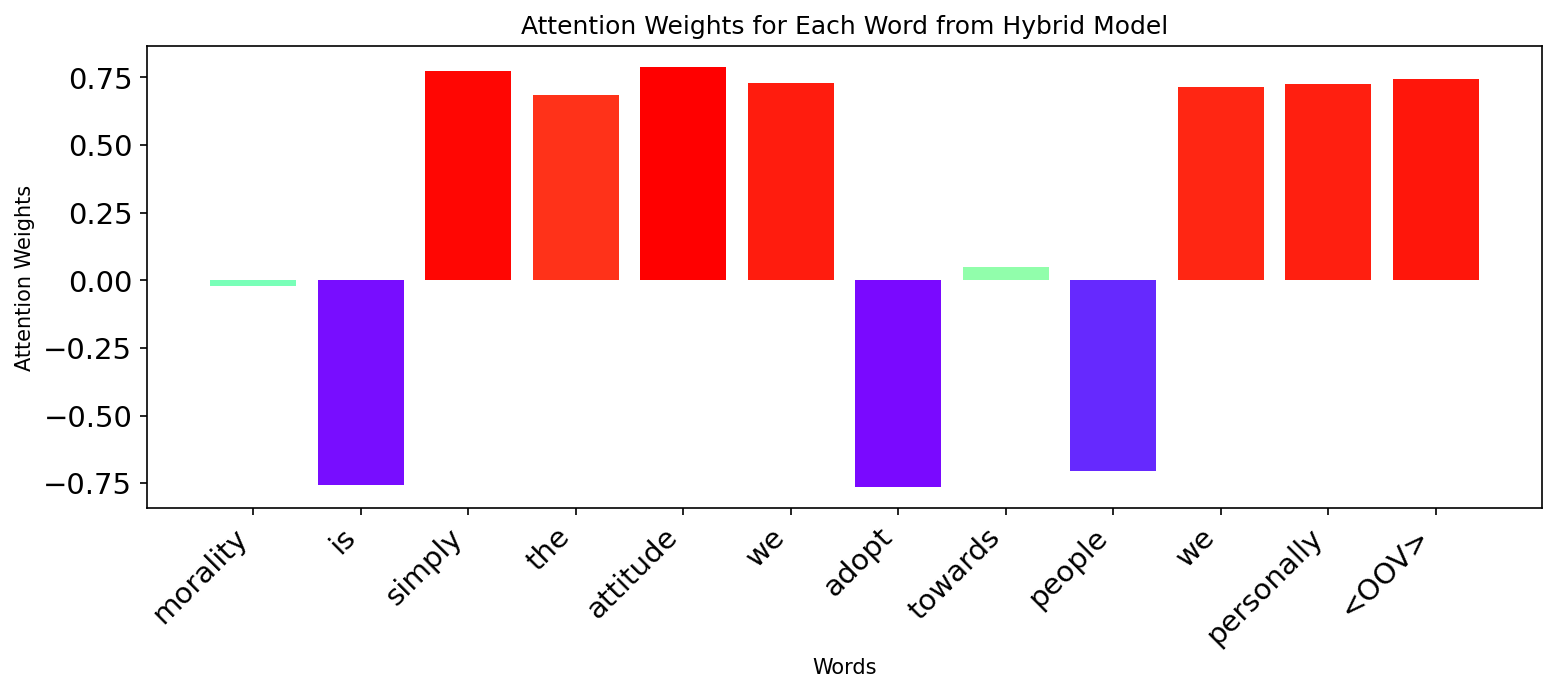

In [ ]:
visualize_attention_weights(example_2, hybrid_model, tokenizer)

1/1 [==============================] - 1s 661ms/step
[[0.00023181]]


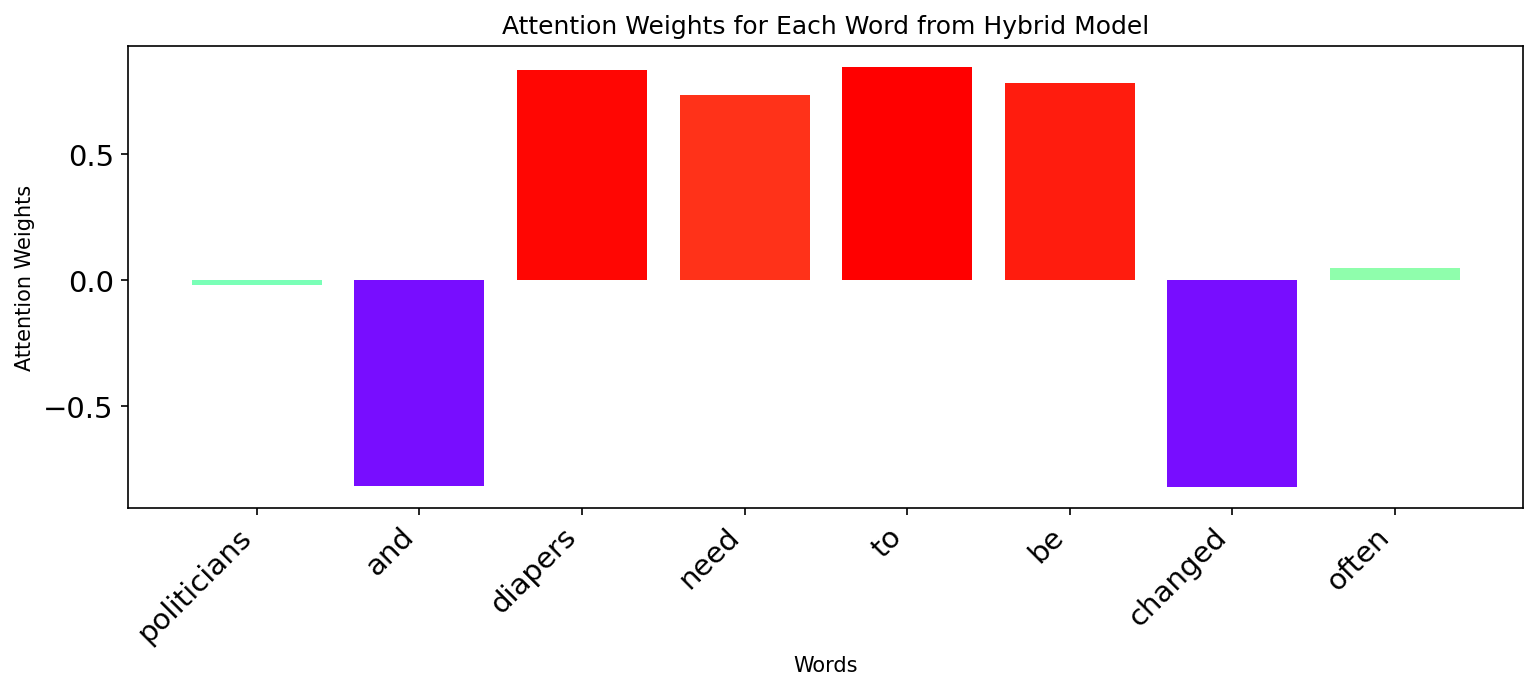

In [ ]:
visualize_attention_weights(example_3, hybrid_model, tokenizer)

1/1 [==============================] - 1s 686ms/step
[[0.9997657]]


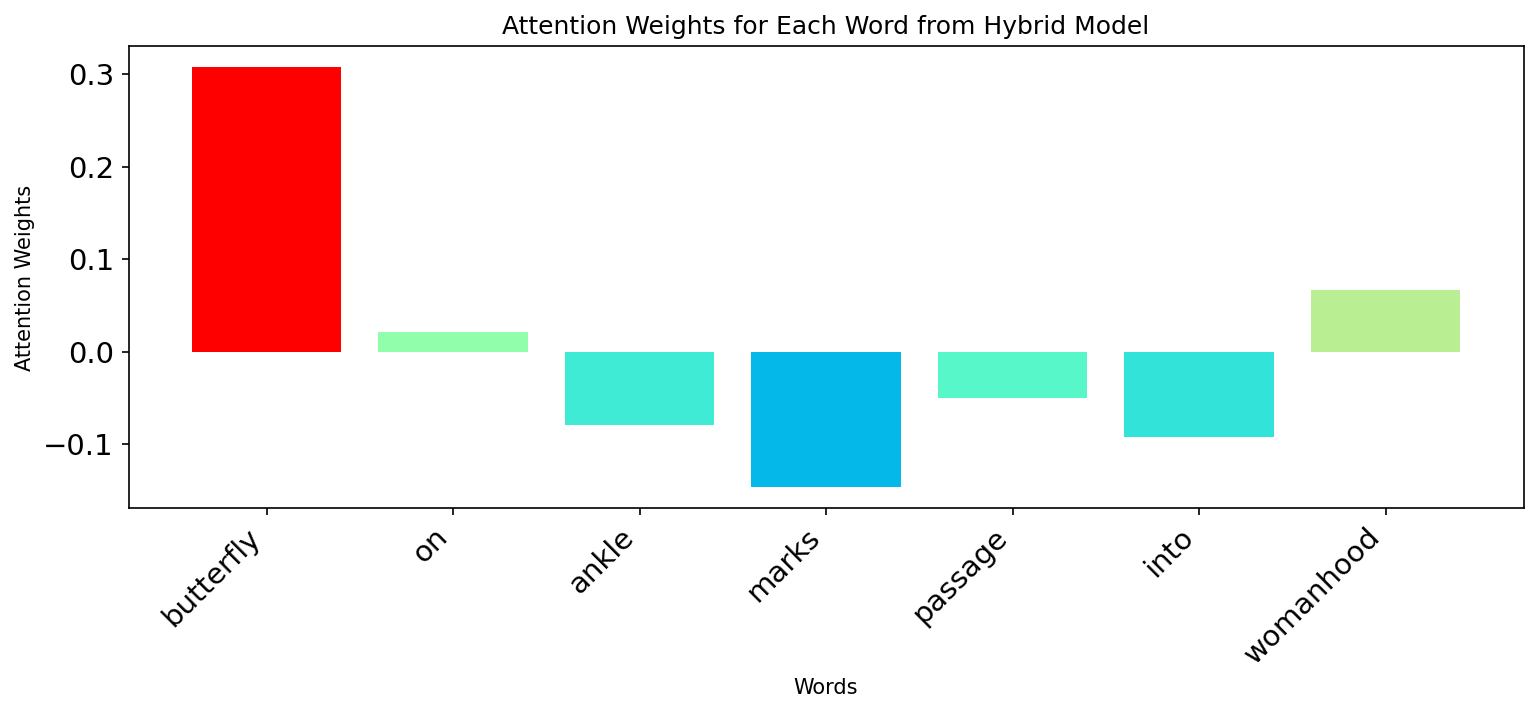

In [ ]:
example_4 = "butterfly on ankle marks passage into womanhood"
visualize_attention_weights(example_4, hybrid_model, tokenizer)

1/1 [==============================] - 1s 657ms/step
[[1.]]


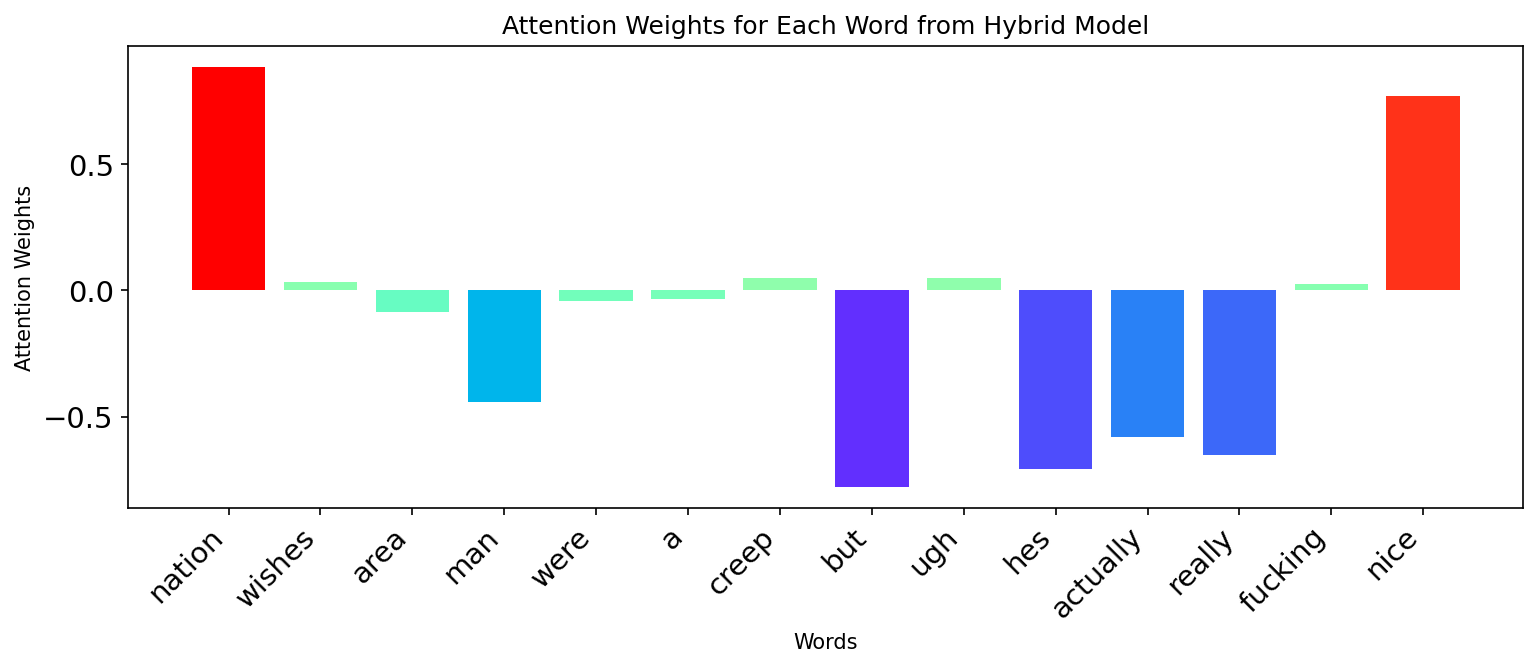

In [ ]:
example_5 = "nation wishes area man were a creep but ugh hes actually really fucking nice"
visualize_attention_weights(example_5, hybrid_model, tokenizer)

1/1 [==============================] - 1s 663ms/step
[[0.9999999]]


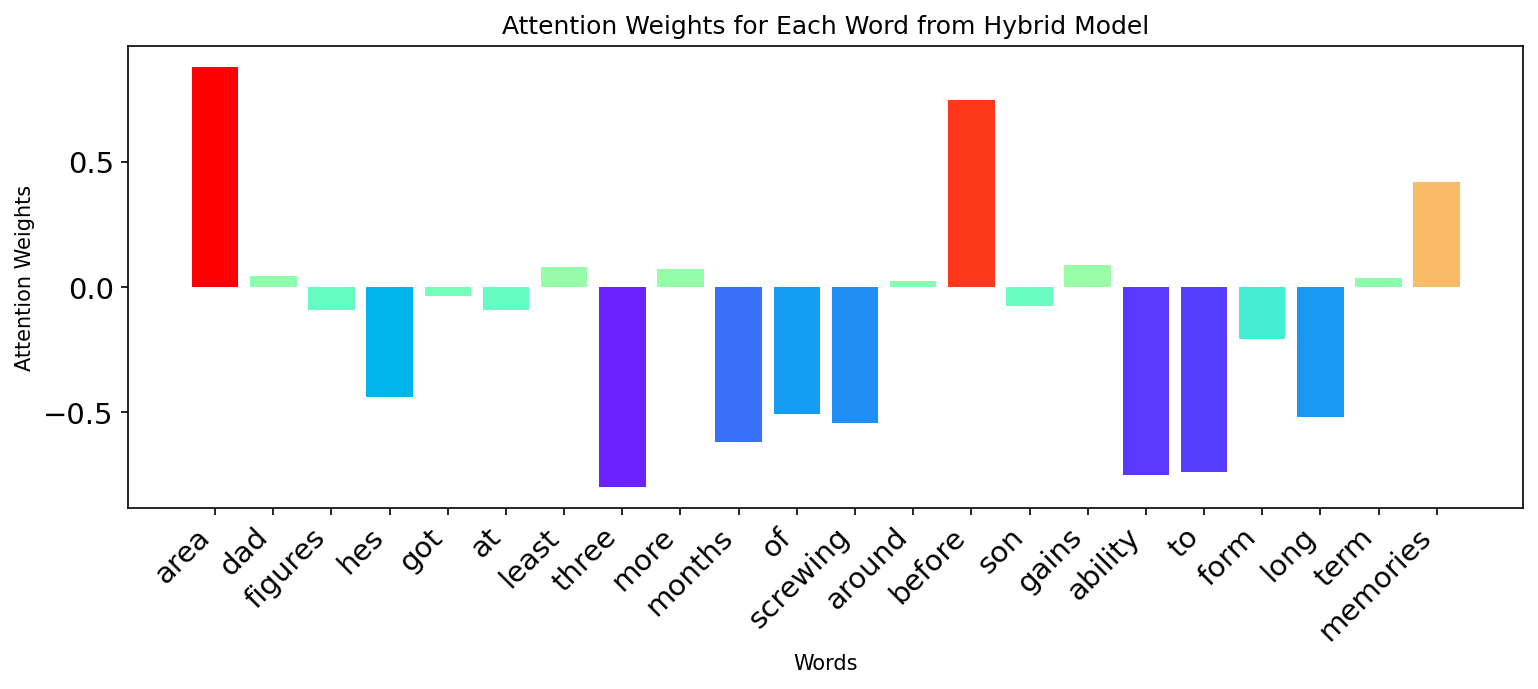

In [ ]:
example_6 = "area dad figures hes got at least three more months of screwing around before son gains ability to form long term memories"
visualize_attention_weights(example_6, hybrid_model, tokenizer)

### Lime: Local Interpretable Model-agnostic Explanations

In [ ]:
# Function to preprocess the text and make predictions using your model
def predict_fn_hybrid(sentences):
    seq  = tokenizer.texts_to_sequences(sentences)
    data = pad_sequences(seq, maxlen=max_sequence_length_train, padding="post")
    predictions = hybrid_model.predict(data)
    # Return probabilities for both classes
    return np.hstack((1 - predictions, predictions))

def predict_fn_attention(sentences):
    seq  = tokenizer.texts_to_sequences(sentences)
    data = pad_sequences(seq, maxlen=max_sequence_length_train, padding="post")
    pred,_ = attention_model.predict(data)
    # Return probabilities for both classes
    return np.hstack((1-pred, pred))

# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=["Not Sarcasm", "Sarcasm"])

157/157 [==============================] - 1s 3ms/step


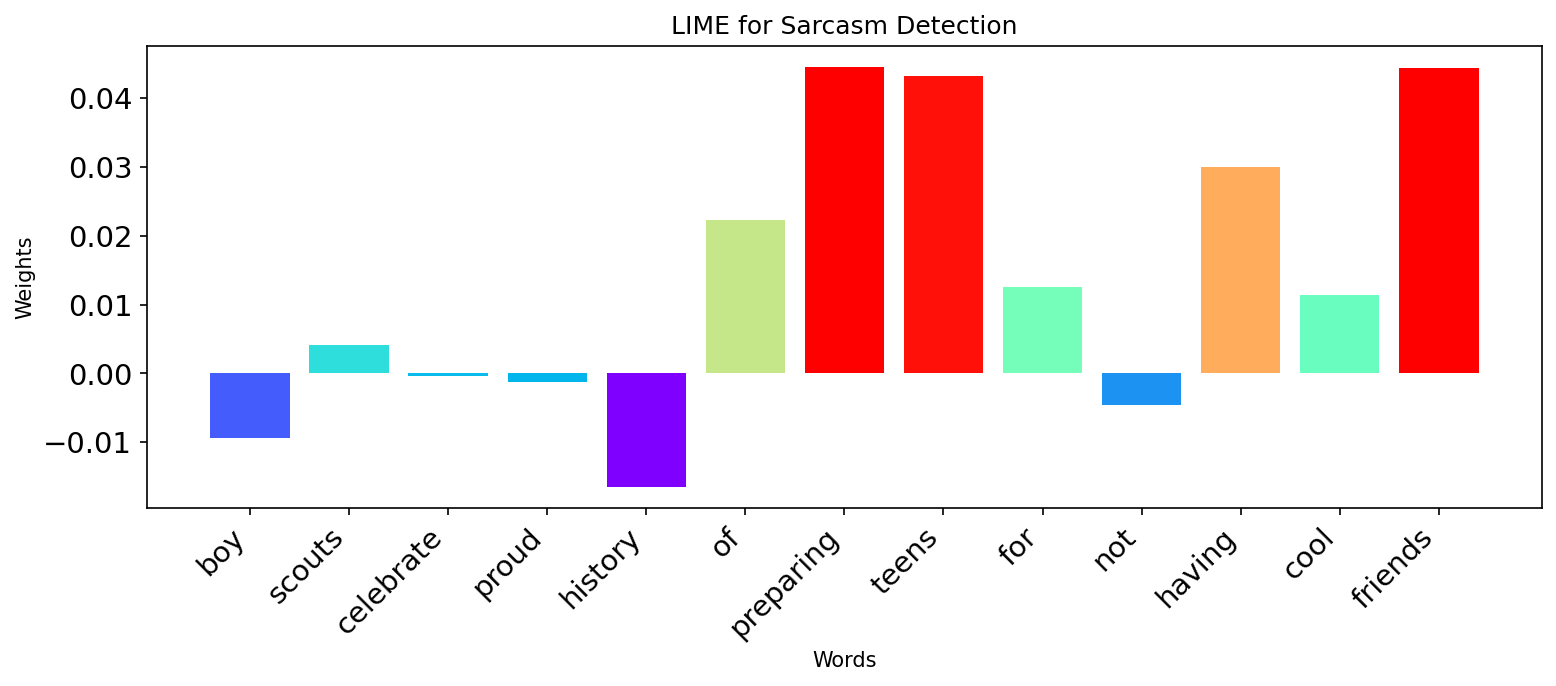

In [ ]:
# Generate explanation
exp = explainer.explain_instance(example_1, predict_fn_hybrid, num_features=15)
exp_list = exp.as_list()

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_1])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict = dict(exp_list)

# Sort the weights by the word order in 'words'
sorted_weights = [exp_dict[word] if word in exp_dict else 0 for word in words]

# Normalize the weights for color mapping
normalized_weights = (np.array(sorted_weights) - np.min(sorted_weights)) / (np.max(sorted_weights) - np.min(sorted_weights))

# Get the corresponding colormap array for the normalized weights
cols = plt.cm.rainbow(normalized_weights)

# Visualize the explanation
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(len(words)), sorted_weights, color=cols)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title("LIME for Sarcasm Detection")
plt.show()

157/157 [==============================] - 1s 5ms/step


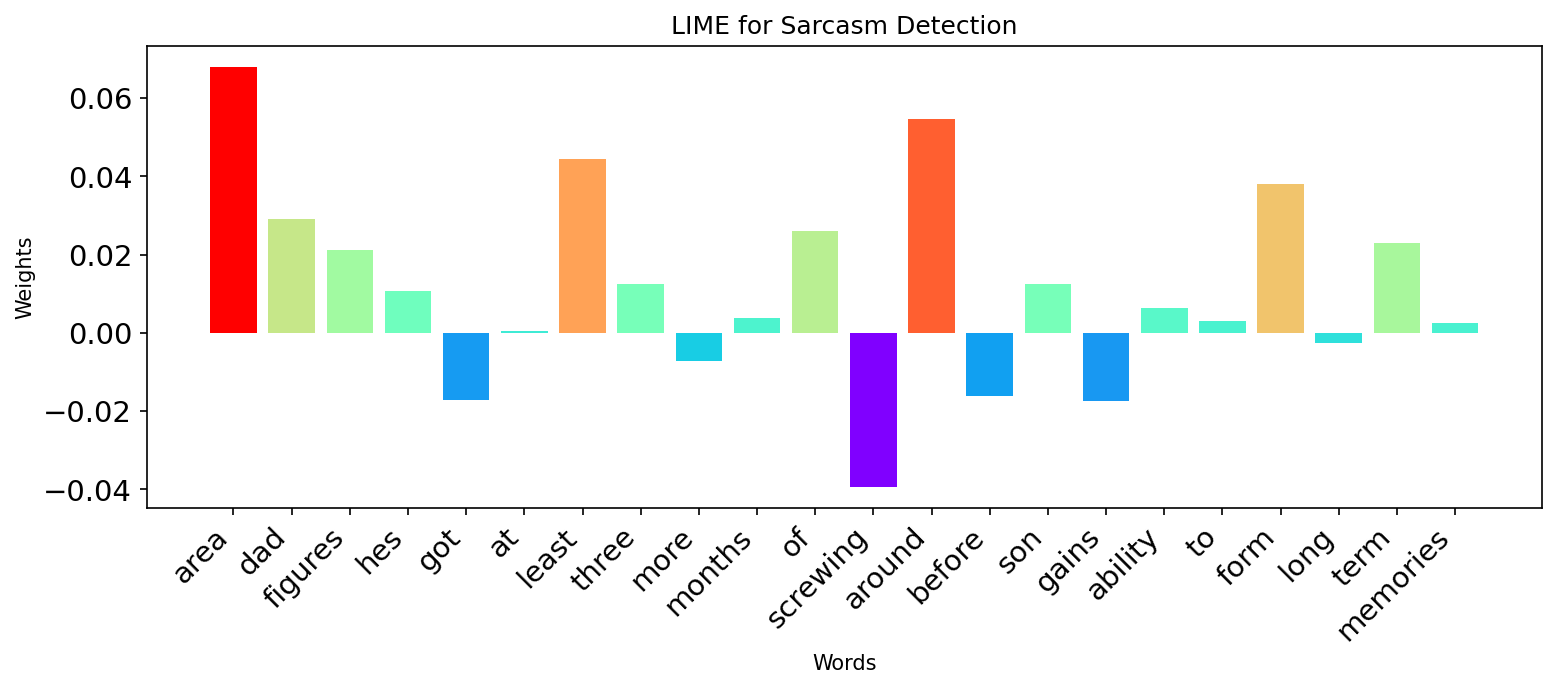

In [ ]:
# Generate explanation
exp = explainer.explain_instance(example_6, predict_fn_hybrid, num_features=30)
exp_list = exp.as_list()

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_6])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict = dict(exp_list)

# Sort the weights by the word order in 'words'
sorted_weights = [exp_dict[word] if word in exp_dict else 0 for word in words]

# Normalize the weights for color mapping
normalized_weights = (np.array(sorted_weights) - np.min(sorted_weights)) / (np.max(sorted_weights) - np.min(sorted_weights))

# Get the corresponding colormap array for the normalized weights
cols = plt.cm.rainbow(normalized_weights)

# Visualize the explanation
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(len(words)), sorted_weights, color=cols)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title("LIME for Sarcasm Detection")
plt.show()

157/157 [==============================] - 1s 5ms/step


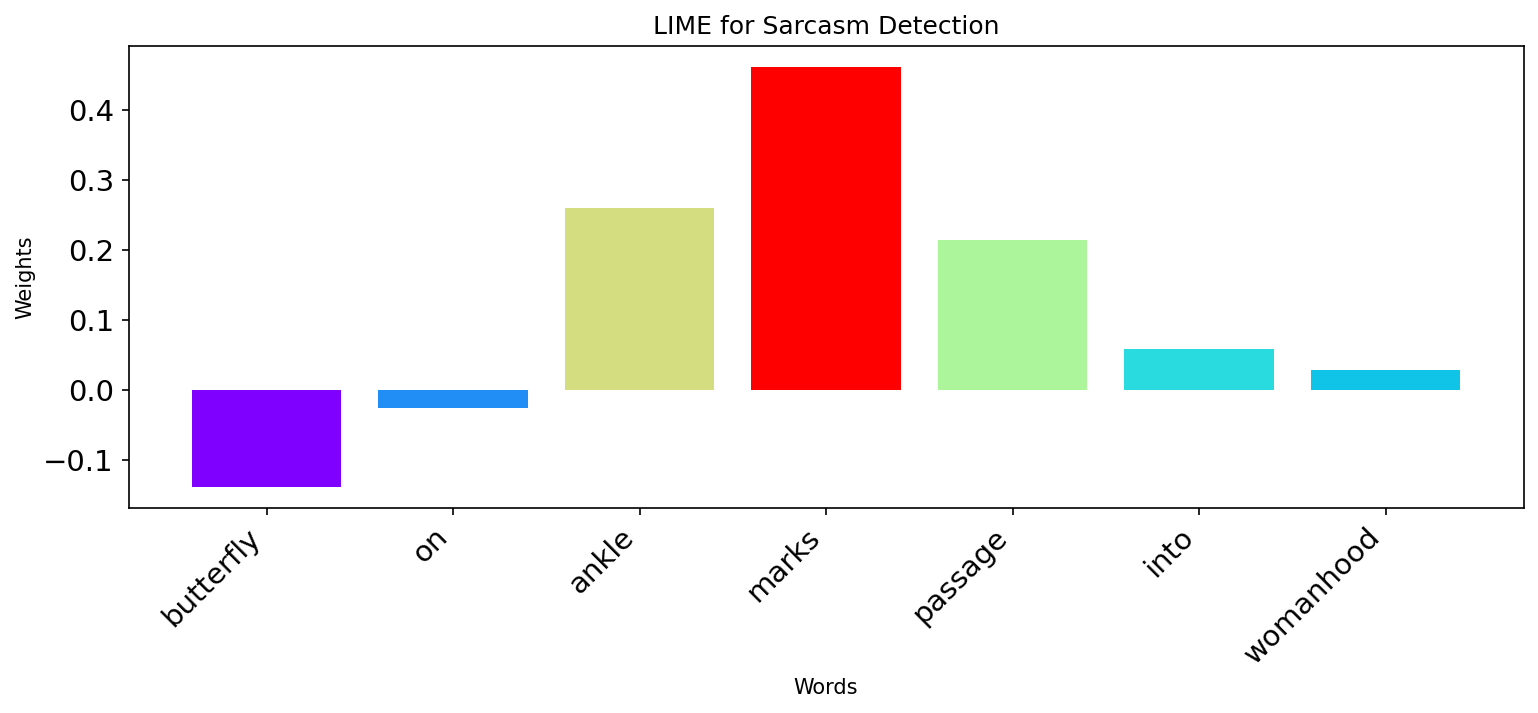

In [ ]:
# Generate explanation
exp = explainer.explain_instance(example_4, predict_fn_hybrid, num_features=15)
exp_list = exp.as_list()

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_4])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict = dict(exp_list)

# Sort the weights by the word order in 'words'
sorted_weights = [exp_dict[word] if word in exp_dict else 0 for word in words]

# Normalize the weights for color mapping
normalized_weights = (np.array(sorted_weights) - np.min(sorted_weights)) / (np.max(sorted_weights) - np.min(sorted_weights))

# Get the corresponding colormap array for the normalized weights
cols = plt.cm.rainbow(normalized_weights)

# Visualize the explanation
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(len(words)), sorted_weights, color=cols)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title("LIME for Sarcasm Detection")
plt.show()

157/157 [==============================] - 1s 5ms/step


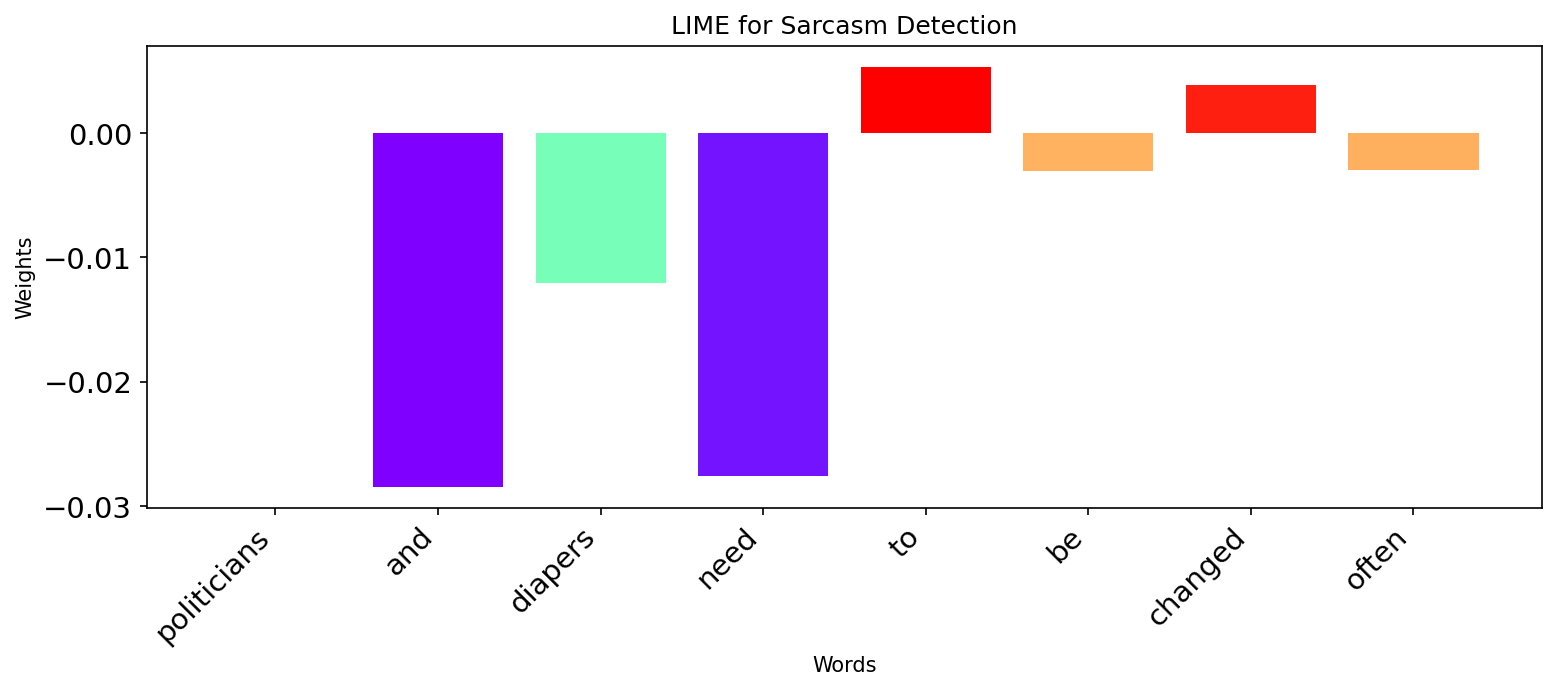

In [ ]:
# Generate explanation
exp = explainer.explain_instance(example_3, predict_fn_hybrid, num_features=30)
exp_list = exp.as_list()

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_3])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict = dict(exp_list)

# Sort the weights by the word order in 'words'
sorted_weights = [exp_dict[word] if word in exp_dict else 0 for word in words]

# Normalize the weights for color mapping
normalized_weights = (np.array(sorted_weights) - np.min(sorted_weights)) / (np.max(sorted_weights) - np.min(sorted_weights))

# Get the corresponding colormap array for the normalized weights
cols = plt.cm.rainbow(normalized_weights)

# Visualize the explanation
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(len(words)), sorted_weights, color=cols)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title("LIME for Sarcasm Detection")
plt.show()

### XAI Comparison

In [ ]:
sequence = tokenizer.texts_to_sequences([example_1])
padded_sequence = pad_sequences(sequence, padding="post",
                                maxlen=max_sequence_length_train)

# Define a submodel to extract the output from attention layer with weights
# Replace with the correct name from the summary, if u've run it many times
attention_layer = hybrid_model.get_layer('attention_layer_2')
submodel = Model(inputs=hybrid_model.input,
                 outputs=[hybrid_model.output, attention_layer.output])

# Generate explanation for both models
exp_1 = explainer.explain_instance(example_1, predict_fn_hybrid, num_features=15)
exp_2 = explainer.explain_instance(example_1, predict_fn_attention, num_features=15)
exp_list_1 = exp_1.as_list()
exp_list_2 = exp_2.as_list()

# Get the prediction and attention weights from both models
prediction_1, att_weights_1 = attention_model.predict(padded_sequence)
prediction_2, att_weights_2 = submodel.predict(padded_sequence)

# The attention_weights might have an extra dimension because of the batch size
# even if it's just one sentence
att_weights_2 = np.squeeze(att_weights_2)

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_1])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict_1 = dict(exp_list_1)
exp_dict_2 = dict(exp_list_2)

# Sort the weights by the word order in 'words'
sorted_weights_1 = [exp_dict_1[word] if word in exp_dict_1 else 0 for word in words]
sorted_weights_2 = [exp_dict_2[word] if word in exp_dict_2 else 0 for word in words]

# trim the weight arrays
actual_length = len(sequence[0])
trimmed_att_weights_1 = att_weights_1[0, :len(example_1.split())].reshape(-1)
trimmed_att_weights_2 = att_weights_2[:actual_length]

# Normalize the weights to [-1, 1]
def normalize_weights(weights):
    max_val = np.max(np.abs(weights))
    return weights / max_val if max_val != 0 else weights

# Normalize each set of weights
# norm_att_weights_1   = normalize_weights(trimmed_att_weights_1)
norm_att_weights_2   = normalize_weights(trimmed_att_weights_2)
norm_lime_weights_1  = normalize_weights(sorted_weights_1)
norm_lime_weights_2  = normalize_weights(sorted_weights_2)

# # Get the corresponding colormap array for the normalized weights
# cols_att_1  = plt.cm.rainbow((normalized_weights_att_1 + 1) / 2)
cols_att_2    = plt.cm.rainbow((norm_att_weights_2 + 1) / 2)
cols_lime_1   = plt.cm.rainbow(norm_lime_weights_1)
# cols_lime_2   = plt.cm.rainbow(norm_lime_weights_2)

1/1 [==============================] - 1s 661ms/step


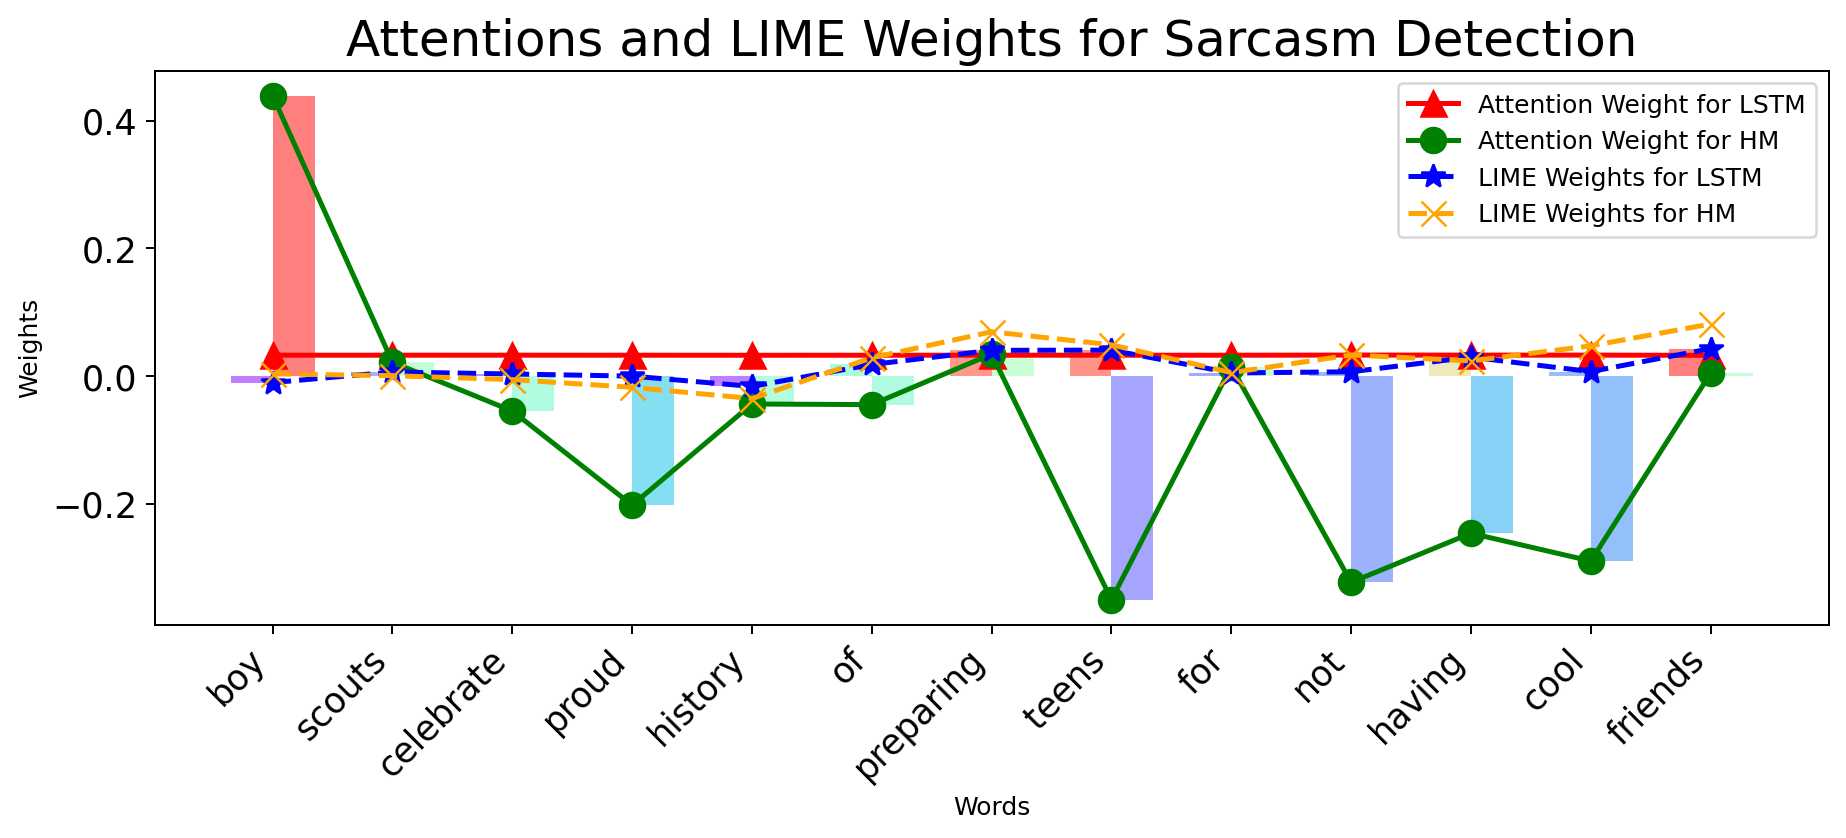

In [ ]:
plt.figure(figsize=(12, 4), dpi=180)

indices   = np.arange(len(words))
bar_width = 0.35
indices_lime = indices - bar_width/2
indices_att2 = indices + bar_width/2

plt.plot(indices, trimmed_att_weights_1, color='red',
         marker='^', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for LSTM')
plt.plot(indices, trimmed_att_weights_2, color='green',
         marker='o', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for HM')
plt.plot(indices, sorted_weights_1, color='blue',
         marker='*', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for LSTM')
plt.plot(indices, sorted_weights_2, color='orange',
         marker='x', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for HM')

plt.bar(indices_att2, trimmed_att_weights_2, bar_width, color=cols_att_2, alpha=.5)
plt.bar(indices_lime, sorted_weights_1, bar_width, color=cols_lime_1, alpha=.5)

plt.xticks(indices, words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title('Attentions and LIME Weights for Sarcasm Detection', size=20)
plt.legend()
plt.show()

**One outside the Dataset**

In [ ]:
example_7 = "I like person better than principles and I like person with no principles better than anything else in the world"
sequence = tokenizer.texts_to_sequences([example_7])
padded_sequence = pad_sequences(sequence, padding="post",
                                maxlen=max_sequence_length_train)

# Define a submodel to extract the output from attention layer with weights
# Replace with the correct name from the summary, if u've run it many times
attention_layer = hybrid_model.get_layer('attention_layer_2')
submodel = Model(inputs=hybrid_model.input,
                 outputs=[hybrid_model.output, attention_layer.output])

# Generate explanation for both models
exp_1 = explainer.explain_instance(example_7, predict_fn_hybrid, num_features=30)
exp_2 = explainer.explain_instance(example_7, predict_fn_attention, num_features=30)
exp_list_1 = exp_1.as_list()
exp_list_2 = exp_2.as_list()

# Get the prediction and attention weights from both models
prediction_1, att_weights_1 = attention_model.predict(padded_sequence)
prediction_2, att_weights_2 = submodel.predict(padded_sequence)

# The attention_weights might have an extra dimension because of the batch size
# even if it's just one sentence
att_weights_2 = np.squeeze(att_weights_2)

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_7])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict_1 = dict(exp_list_1)
exp_dict_2 = dict(exp_list_2)

# Sort the weights by the word order in 'words'
sorted_weights_1 = [exp_dict_1[word] if word in exp_dict_1 else 0 for word in words]
sorted_weights_2 = [exp_dict_2[word] if word in exp_dict_2 else 0 for word in words]

# trim the weight arrays
actual_length = len(sequence[0])
trimmed_att_weights_1 = att_weights_1[0, :len(example_7.split())].reshape(-1)
trimmed_att_weights_2 = att_weights_2[:actual_length]

# Normalize the weights to [-1, 1]
def normalize_weights(weights):
    max_val = np.max(np.abs(weights))
    return weights / max_val if max_val != 0 else weights

# Normalize each set of weights
# norm_att_weights_1   = normalize_weights(trimmed_att_weights_1)
norm_att_weights_2   = normalize_weights(trimmed_att_weights_2)
norm_lime_weights_1  = normalize_weights(sorted_weights_1)
norm_lime_weights_2  = normalize_weights(sorted_weights_2)

# # Get the corresponding colormap array for the normalized weights
# cols_att_1  = plt.cm.rainbow((normalized_weights_att_1 + 1) / 2)
cols_att_2    = plt.cm.rainbow((norm_att_weights_2 + 1) / 2)
cols_lime_1   = plt.cm.rainbow(norm_lime_weights_1)
# cols_lime_2   = plt.cm.rainbow(norm_lime_weights_2)

1/1 [==============================] - 1s 660ms/step


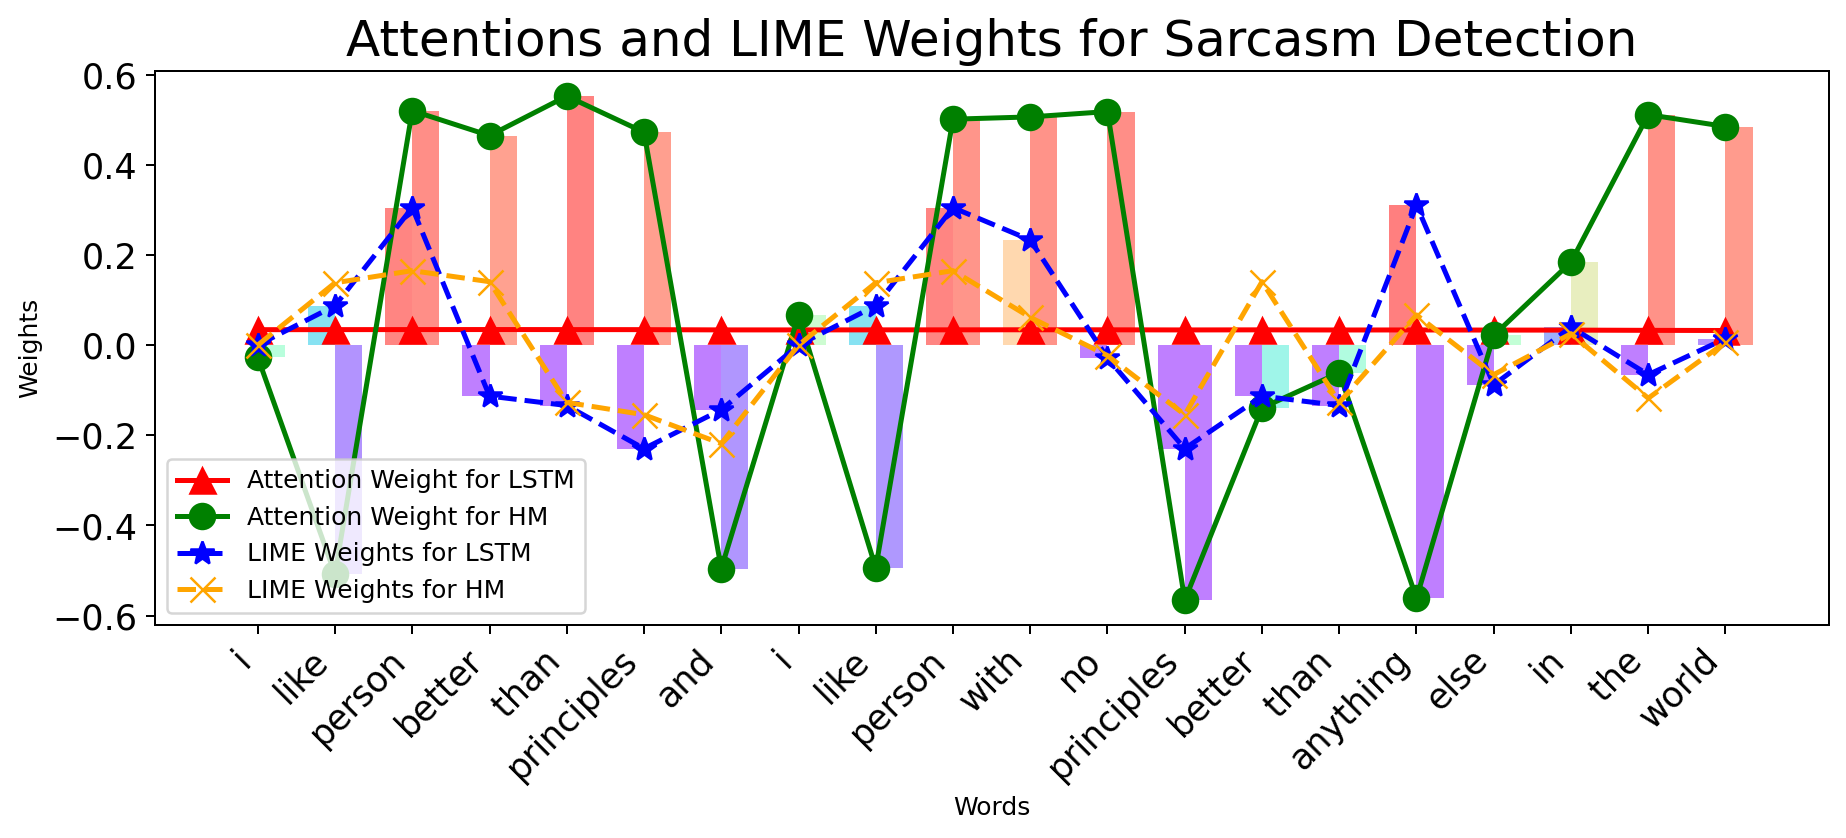

In [ ]:
plt.figure(figsize=(12, 4), dpi=180)

indices   = np.arange(len(words))
bar_width = 0.35
indices_lime = indices - bar_width/2
indices_att2 = indices + bar_width/2

plt.plot(indices, trimmed_att_weights_1, color='red',
         marker='^', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for LSTM')
plt.plot(indices, trimmed_att_weights_2, color='green',
         marker='o', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for HM')
plt.plot(indices, sorted_weights_1, color='blue',
         marker='*', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for LSTM')
plt.plot(indices, sorted_weights_2, color='orange',
         marker='x', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for HM')

plt.bar(indices_att2, trimmed_att_weights_2, bar_width, color=cols_att_2, alpha=.5)
plt.bar(indices_lime, sorted_weights_1, bar_width, color=cols_lime_1, alpha=.5)

plt.xticks(indices, words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title('Attentions and LIME Weights for Sarcasm Detection', size=20)
plt.legend()
plt.show()

## Model: Transformer

In [ ]:
# Define a dataset
dataset = tf.data.Dataset.from_tensor_slices((padded_seq_train, labels_train))
dataset = dataset.shuffle(len(padded_seq_train), reshuffle_each_iteration=True).batch(128, drop_remainder=True)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# define a verification dataset
val_dataset = tf.data.Dataset.from_tensor_slices((padded_seq_test, labels_test))
val_dataset = val_dataset.batch(len(padded_seq_test), drop_remainder=True)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # # dot product with Values
    # attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)

    # return attention

    # Calculate the attention weights
    attention_weights = tf.nn.softmax(scaled_product, axis=-1)

    # Apply the attention weights to the values
    attention = tf.matmul(attention_weights, values)

    return attention, attention_weights

class MultiHeadAttention(layers.Layer):

    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)

    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)

    def call(self, queries, keys, values, mask, return_attention_weights=False):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)

        # Apply scaled dot product attention
        if return_attention_weights:
            attention_output, attention_weights = scaled_dot_product_attention(queries, keys, values, mask)
        else:
            attention_output, _ = scaled_dot_product_attention(queries, keys, values, mask)

        # # Apply the scaled dot product
        # attention = scaled_dot_product_attention(queries, keys, values, mask)
        # # Get the attention scores
        # attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # # Concat the h heads or projections
        # concat_attention = tf.reshape(attention,
        #                               shape=(batch_size, -1, self.d_model))
        # # Apply W0 to get the output of the multi-head attention
        # outputs = self.final_lin(concat_attention)

        # Reshape and concatenate the heads
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention_output, shape=(batch_size, -1, self.d_model))

        # Apply the final linear layer
        outputs = self.final_lin(concat_attention)

        if return_attention_weights:
            return outputs, attention_weights
        else:
            return outputs
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]

        return inputs + tf.cast(pos_encoding, tf.float32)
class EncoderLayer(layers.Layer):

    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask, training, return_attention_weights=False):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,inputs,inputs,mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)

        if return_attention_weights:
            attention, attention_weights = self.multi_head_attention(inputs, inputs, inputs, mask, return_attention_weights)
        else:
            attention = self.multi_head_attention(inputs, inputs, inputs, mask)

        if return_attention_weights:
            return outputs, attention_weights
        else:
            return outputs
class Encoder(layers.Layer):

    def __init__(self, n_layers, FFN_units, n_heads, dropout_rate, vocab_size,
                 d_model, name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate)
                           for _ in range(n_layers)]
        self.last_linear = layers.Dense(units=2, name="lin_ouput")

    def call(self, inputs, mask, training, return_attention_weights=False):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        logits=tf.math.reduce_mean(outputs,1)
        logits=self.last_linear(logits)

        attention_weights_list = []
        for i in range(self.n_layers):
            if return_attention_weights:
                outputs, attention_weights = self.enc_layers[i](outputs, mask, training, return_attention_weights)
                attention_weights_list.append(attention_weights)
            else:
                outputs = self.enc_layers[i](outputs, mask, training)

        if return_attention_weights:
            return logits, attention_weights_list
        else:
            return logits #outputs[:,0:1,:]
def create_padding_mask(seq): #seq: (batch_size, seq_length)
# Create the mask for padding
  mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]
def loss_function(target, pred):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(target,pred)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)



In [ ]:
def main_train(dataset, val_dataset, encoder, n_epochs, train_loss, train_accuracy):
    ''' Train the transformer model for n_epochs using the data generator dataset'''
    epoch_train_losses = []
    epoch_train_accuracies = []
    epoch_val_losses = []
    epoch_val_accuracies = []
    print_every = 50

    # In every epoch
    for epoch in range(n_epochs):
        print("Starting epoch {}".format(epoch + 1))

        # Reset the loss and accuracy calculations
        train_loss.reset_states()
        train_accuracy.reset_states()

        # Training loop
        for (batch, (inputs, targets)) in enumerate(dataset):
            targets = pd.get_dummies(targets).astype('float').values
            with tf.GradientTape() as tape:
                predictions = encoder(inputs, create_padding_mask(inputs), True)
                loss = loss_function(targets, predictions)

            gradients = tape.gradient(loss, encoder.trainable_variables)
            optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
            train_loss(loss)
            train_accuracy(targets, predictions)

            if batch % print_every == 0:
                print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                    epoch + 1, batch, train_loss.result(), train_accuracy.result()))

        epoch_train_losses.append(train_loss.result().numpy())
        epoch_train_accuracies.append(train_accuracy.result().numpy())

        # Validation loop
        val_loss = tf.keras.metrics.Mean(name="val_loss")
        val_accuracy = tf.keras.metrics.BinaryAccuracy(name="val_accuracy")
        for inputs, targets in val_dataset:
            targets = pd.get_dummies(targets).astype('float').values
            predictions = encoder(inputs, create_padding_mask(inputs), False)
            loss = loss_function(targets, predictions)
            val_loss(loss)
            val_accuracy(targets, predictions)

        epoch_val_losses.append(val_loss.result().numpy())
        epoch_val_accuracies.append(val_accuracy.result().numpy())

        print(f"Epoch {epoch + 1} completed. Training loss: {epoch_train_losses[-1]}, Validation loss: {epoch_val_losses[-1]}, Training accuracy: {epoch_train_accuracies[-1]}, Validation accuracy: {epoch_val_accuracies[-1]}")

    return epoch_train_losses, epoch_train_accuracies, epoch_val_losses, epoch_val_accuracies


In [ ]:
tf.keras.backend.clear_session()
# Create the Encoder model
encoder = Encoder(6,512,8,0.1,len(word_index),256)
# (self, n_layers, FFN_units, n_heads, dropout_rate, vocab_size, d_model, name="encoder")

# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(256)

# # Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

# run training
epoch_train_losses, epoch_train_accuracies, epoch_val_losses, epoch_val_accuracies = main_train(dataset, val_dataset, encoder, 5, train_loss, train_accuracy)


Starting epoch 1


Epoch 1 Batch 0 Loss 0.9109 Accuracy 0.5117
Epoch 1 Batch 50 Loss 0.7694 Accuracy 0.5060
Epoch 1 Batch 100 Loss 0.7206 Accuracy 0.5307
Epoch 1 Batch 150 Loss 0.6785 Accuracy 0.5700
Epoch 1 completed. Training loss: 0.6776658892631531, Validation loss: 0.5431471467018127, Training accuracy: 0.57080078125, Validation accuracy: 0.7133933901786804
Starting epoch 2
Epoch 2 Batch 0 Loss 0.5149 Accuracy 0.7305
Epoch 2 Batch 50 Loss 0.5315 Accuracy 0.7152
Epoch 2 Batch 100 Loss 0.5140 Accuracy 0.7300
Epoch 2 Batch 150 Loss 0.4898 Accuracy 0.7476
Epoch 2 completed. Training loss: 0.4896408021450043, Validation loss: 0.397991418838501, Training accuracy: 0.7476356625556946, Validation accuracy: 0.8057546615600586
Starting epoch 3
Epoch 3 Batch 0 Loss 0.3373 Accuracy 0.8633
Epoch 3 Batch 50 Loss 0.3755 Accuracy 0.8278
Epoch 3 Batch 100 Loss 0.3701 Accuracy 0.8304
Epoch 3 Batch 150 Loss 0.3636 Accuracy 0.8335
Epoch 3 completed. Training loss: 0.364180326461792, Validation loss: 0.3814198672771454,

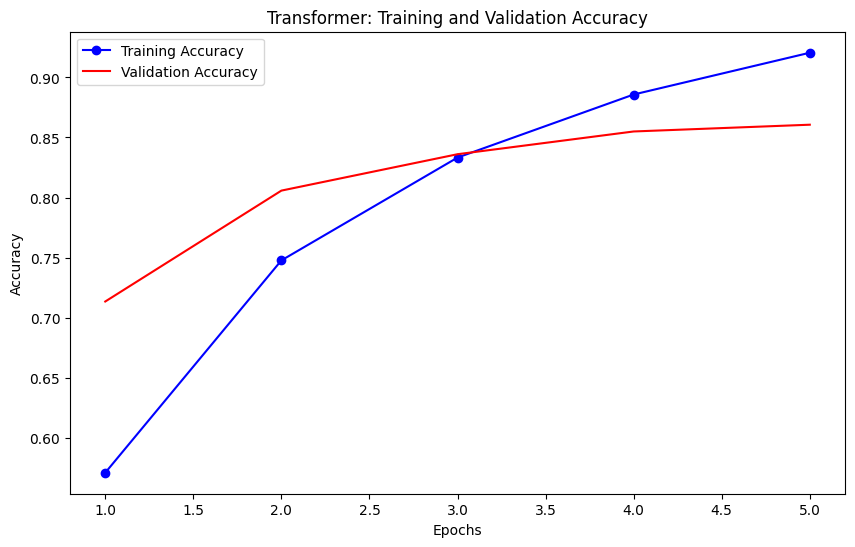

Test Accuracy: 86.38%
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2559
           1       0.84      0.88      0.86      2324

    accuracy                           0.86      4883
   macro avg       0.86      0.86      0.86      4883
weighted avg       0.86      0.86      0.86      4883



In [ ]:
from sklearn.metrics import classification_report

epochs = range(1, len(epoch_train_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, epoch_val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Transformer: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

def predict(encoder,tokenized_sentences):
  logits=encoder(tokenized_sentences,create_padding_mask(tokenized_sentences),False)
  predictions=np.argmax(tf.keras.layers.Softmax()(logits),axis=1)
  return predictions

predicted_labels = predict(encoder, padded_seq_test)
test_accuracy = np.mean(predicted_labels == labels_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print(classification_report(labels_test, predicted_labels))


In [ ]:
example = "inclement weather prevents liar from getting to work"
sequence = tokenizer.texts_to_sequences([example])

padded_sentence = pad_sequences(sequence, padding="post", maxlen=max_sequence_length_train)
print(example)
print(predict(encoder, padded_sentence))


inclement weather prevents liar from getting to work
[1]


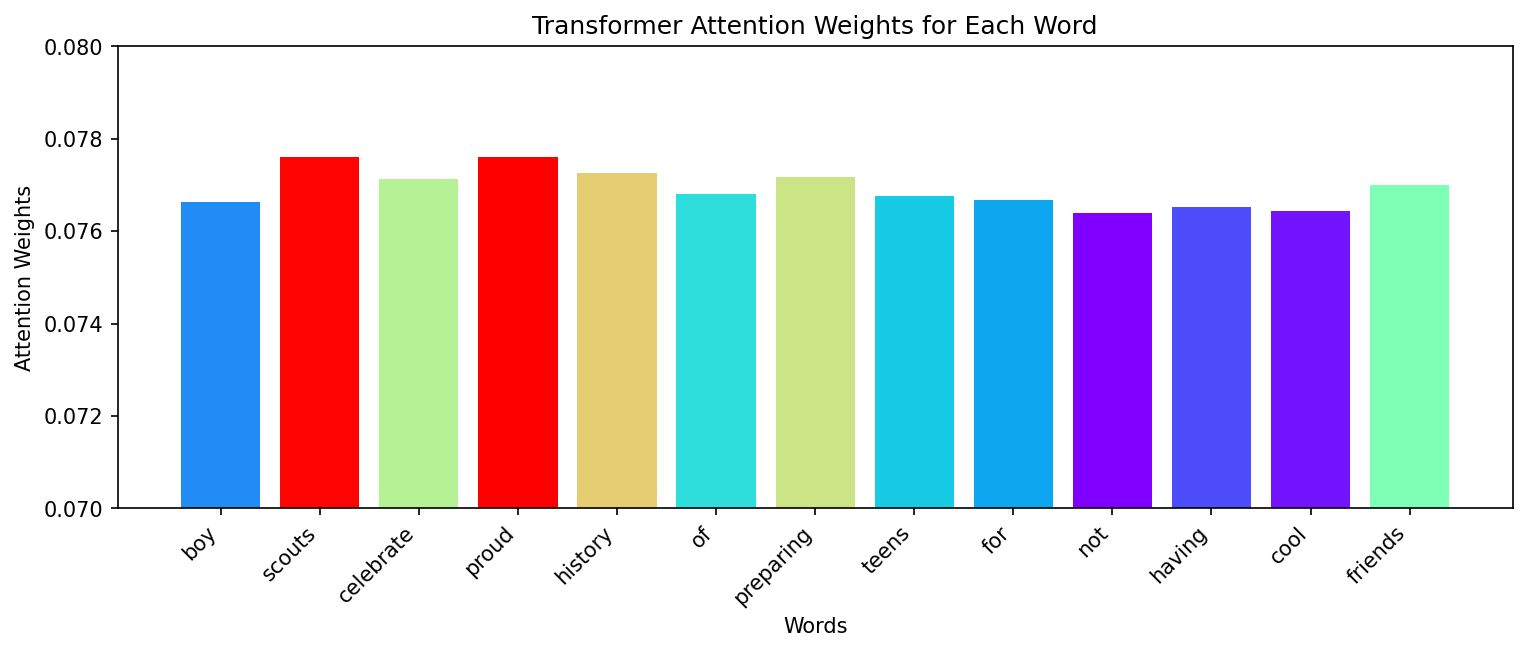

In [ ]:
def visualize_transformer_attention(sentence, encoder, tokenizer, max_sequence_length):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, padding="post", maxlen=max_sequence_length)

    logits, attention_weights_list = encoder(padded_sequence, create_padding_mask(padded_sequence), False, return_attention_weights=True)

    avg_attention_weights_per_layer = []
    for attention_weights in attention_weights_list:
        avg_attention_weights = np.mean(attention_weights[0], axis=0)  # shape: (seq_length, seq_length)
        avg_attention_weights_per_layer.append(avg_attention_weights)

    avg_attention_weights = np.mean(avg_attention_weights_per_layer, axis=0)  # shape: (seq_length, seq_length)

    token_attention_weights = avg_attention_weights[0]

    tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
    words = [tokenizer.index_word[token] for token in tokenized_sentence if token in tokenizer.index_word]
    num_words = min(len(words), len(token_attention_weights))

    # Normalize the weights for color mapping
    normalized_weights = (token_attention_weights[:num_words] - np.min(token_attention_weights[:num_words])) / (np.max(token_attention_weights[:num_words]) - np.min(token_attention_weights[:num_words]))
    cols = cm.rainbow(normalized_weights)

    # Visualize the attention weights
    plt.figure(figsize=(12, 4), dpi=150)
    plt.bar(range(num_words), token_attention_weights[:num_words], color=cols)
    plt.xticks(range(num_words), words, rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Attention Weights')
    plt.ylim(0.07, 0.08)
    plt.title('Transformer Attention Weights for Each Word')
    plt.show()

# Example usage
sentence = example_1
visualize_transformer_attention(sentence, encoder, tokenizer, max_sequence_length_train)


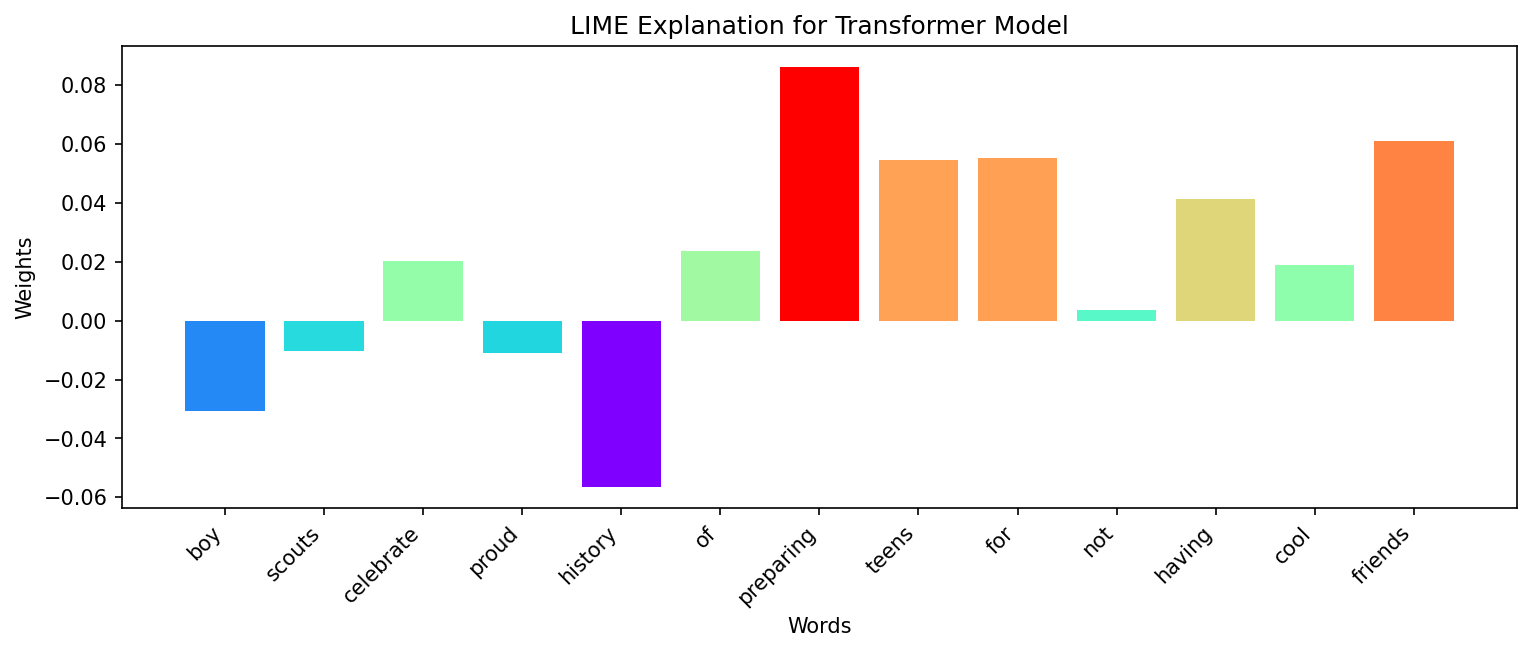

In [ ]:
def predict_proba_lime(sentences):
    # Tokenize and pad the input sentences
    seq = tokenizer.texts_to_sequences(sentences)
    data = pad_sequences(seq, maxlen=max_sequence_length_train, padding="post")

    # Predict using the encoder
    logits = encoder(data, create_padding_mask(data), False)
    predictions = tf.keras.layers.Softmax()(logits).numpy()  # Convert logits to probabilities

    return predictions
# Test the prediction function
test_sentences = ["This is a test sentence.", "Another test sentence."]
test_predictions = predict_proba_lime(test_sentences)

# Generate explanation for a given example
exp = explainer.explain_instance(example_1, predict_proba_lime, num_features=15, num_samples=100)
exp_list = exp.as_list()

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_1])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict = dict(exp_list)

# Sort the weights by the word order in 'words'
sorted_weights = [exp_dict.get(word, 0) for word in words]

# Normalize the weights for color mapping
normalized_weights = (np.array(sorted_weights) - np.min(sorted_weights)) / (np.max(sorted_weights) - np.min(sorted_weights))

# Get the corresponding colormap array for the normalized weights
cols = cm.rainbow(normalized_weights)

# Visualize the explanation
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(len(words)), sorted_weights, color=cols)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.title("LIME Explanation for Transformer Model")
plt.show()


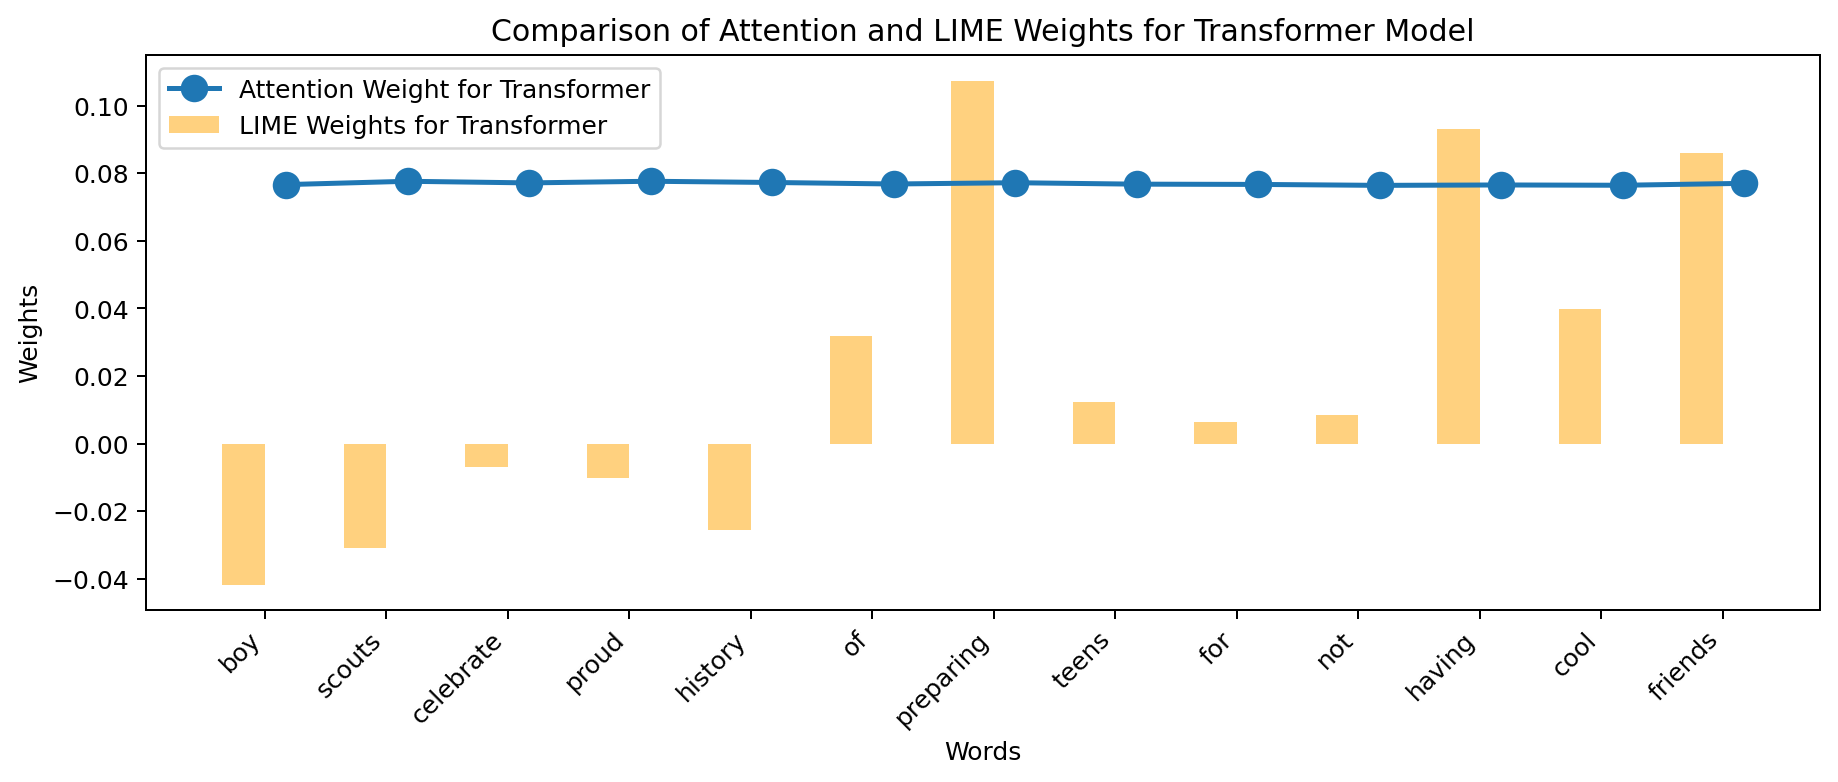

In [ ]:
def visualize_combined_transformer_and_lime(sentence, encoder, tokenizer, max_sequence_length, explainer, predict_fn):
    # Transformer attention visualization setup
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, padding="post", maxlen=max_sequence_length)
    logits, attention_weights_list = encoder(padded_sequence, create_padding_mask(padded_sequence), False, return_attention_weights=True)

    avg_attention_weights_per_layer = []
    for attention_weights in attention_weights_list:
        avg_attention_weights = np.mean(attention_weights[0], axis=0)
        avg_attention_weights_per_layer.append(avg_attention_weights)

    avg_attention_weights = np.mean(avg_attention_weights_per_layer, axis=0)
    token_attention_weights = avg_attention_weights[0]
    token_attention_weights = token_attention_weights[:len(sequence[0])]  # Trim to the length of the sentence

    # LIME explanation setup
    exp = explainer.explain_instance(sentence, predict_fn, num_features=15)
    exp_list = exp.as_list()
    exp_dict = dict(exp_list)
    sorted_weights = [exp_dict.get(word, 0) for word in tokenizer.sequences_to_texts([sequence[0]])[0].split()]

    # Plot setup
    plt.figure(figsize=(12, 4), dpi=180)

    indices = np.arange(len(sorted_weights))
    bar_width = 0.35
    indices_lime = indices - bar_width/2
    indices_attention = indices + bar_width/2

    # Plotting Transformer Attention Weights
    plt.plot(indices_attention, token_attention_weights, marker='o', linestyle='-', linewidth=2, markersize=10, label='Attention Weight for Transformer')

    # Plotting LIME Weights
    plt.bar(indices_lime, sorted_weights, bar_width, alpha=0.5, color='orange', label='LIME Weights for Transformer')

    # Setting up the plot
    plt.xticks(indices, tokenizer.sequences_to_texts([sequence[0]])[0].split(), rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Weights')
    plt.title('Comparison of Attention and LIME Weights for Transformer Model')
    plt.legend()

    # Show the plot
    plt.show()

# Example usage
visualize_combined_transformer_and_lime(example_1, encoder, tokenizer, max_sequence_length_train, explainer, predict_proba_lime)


## XAI Comparison with 3 models

In [ ]:
sequence = tokenizer.texts_to_sequences([example_1])
padded_sequence = pad_sequences(sequence, padding="post",
                                maxlen=max_sequence_length_train)

# Define a submodel to extract the output from attention layer with weights
# Replace with the correct name from the summary, if u've run it many times
attention_layer = hybrid_model.get_layer('attention_layer_2')
submodel = Model(inputs=hybrid_model.input,
                 outputs=[hybrid_model.output, attention_layer.output])

# Generate explanation for both models
exp_1 = explainer.explain_instance(example_1, predict_fn_hybrid, num_features=15)
exp_2 = explainer.explain_instance(example_1, predict_fn_attention, num_features=15)
exp_3 = explainer.explain_instance(example_1, predict_proba_lime, num_features=15,
                                   num_samples=100)
exp_list_1 = exp_1.as_list()
exp_list_2 = exp_2.as_list()
exp_list_3 = exp_3.as_list()

# Get the prediction and attention weights from models
prediction_1, att_weights_1 = attention_model.predict(padded_sequence)
prediction_2, att_weights_2 = submodel.predict(padded_sequence)
_, att_weights_list = encoder(padded_sequence, create_padding_mask(padded_sequence),
                           False, return_attention_weights=True)
avg_att_weights_per_layer = []
for attention_weights in att_weights_list:
    avg_att_weights = np.mean(attention_weights[0], axis=0)  # shape: (seq_length, seq_length)
    avg_att_weights_per_layer.append(avg_att_weights)
avg_att_weights = np.mean(avg_att_weights_per_layer, axis=0)

# The attention_weights might have an extra dimension because of the batch size
# even if it's just one sentence
att_weights_2 = np.squeeze(att_weights_2)
att_weights_3 = avg_att_weights[0]

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_1])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict_1 = dict(exp_list_1)
exp_dict_2 = dict(exp_list_2)
exp_dict_3 = dict(exp_list_3)

# Sort the weights by the word order in 'words'
sorted_weights_1 = [exp_dict_1[word] if word in exp_dict_1 else 0 for word in words]
sorted_weights_2 = [exp_dict_2[word] if word in exp_dict_2 else 0 for word in words]
sorted_weights_3 = [exp_dict_3[word] if word in exp_dict_3 else 0 for word in words]

# trim the weight arrays
actual_length = len(sequence[0])
trimmed_att_weights_1 = att_weights_1[0, :len(example_1.split())].reshape(-1)
trimmed_att_weights_2 = att_weights_2[:actual_length]
trimmed_att_weights_3 = att_weights_3[:actual_length]

# Normalize the weights to [-1, 1]
def normalize_weights(weights):
    max_val = np.max(np.abs(weights))
    return weights / max_val if max_val != 0 else weights

# Normalize each set of weights
# norm_att_weights_1   = normalize_weights(trimmed_att_weights_1)
norm_att_weights_2   = normalize_weights(trimmed_att_weights_2)
norm_lime_weights_1  = normalize_weights(sorted_weights_1)
norm_lime_weights_2  = normalize_weights(sorted_weights_2)
norm_lime_weights_3  = normalize_weights(sorted_weights_3)

# # Get the corresponding colormap array for the normalized weights
# cols_att_1  = plt.cm.rainbow((normalized_weights_att_1 + 1) / 2)
cols_att_2    = plt.cm.rainbow((norm_att_weights_2 + 1) / 2)
cols_lime_1   = plt.cm.rainbow(norm_lime_weights_1)
# cols_lime_2   = plt.cm.rainbow(norm_lime_weights_2)

1/1 [==============================] - 2s 2s/step


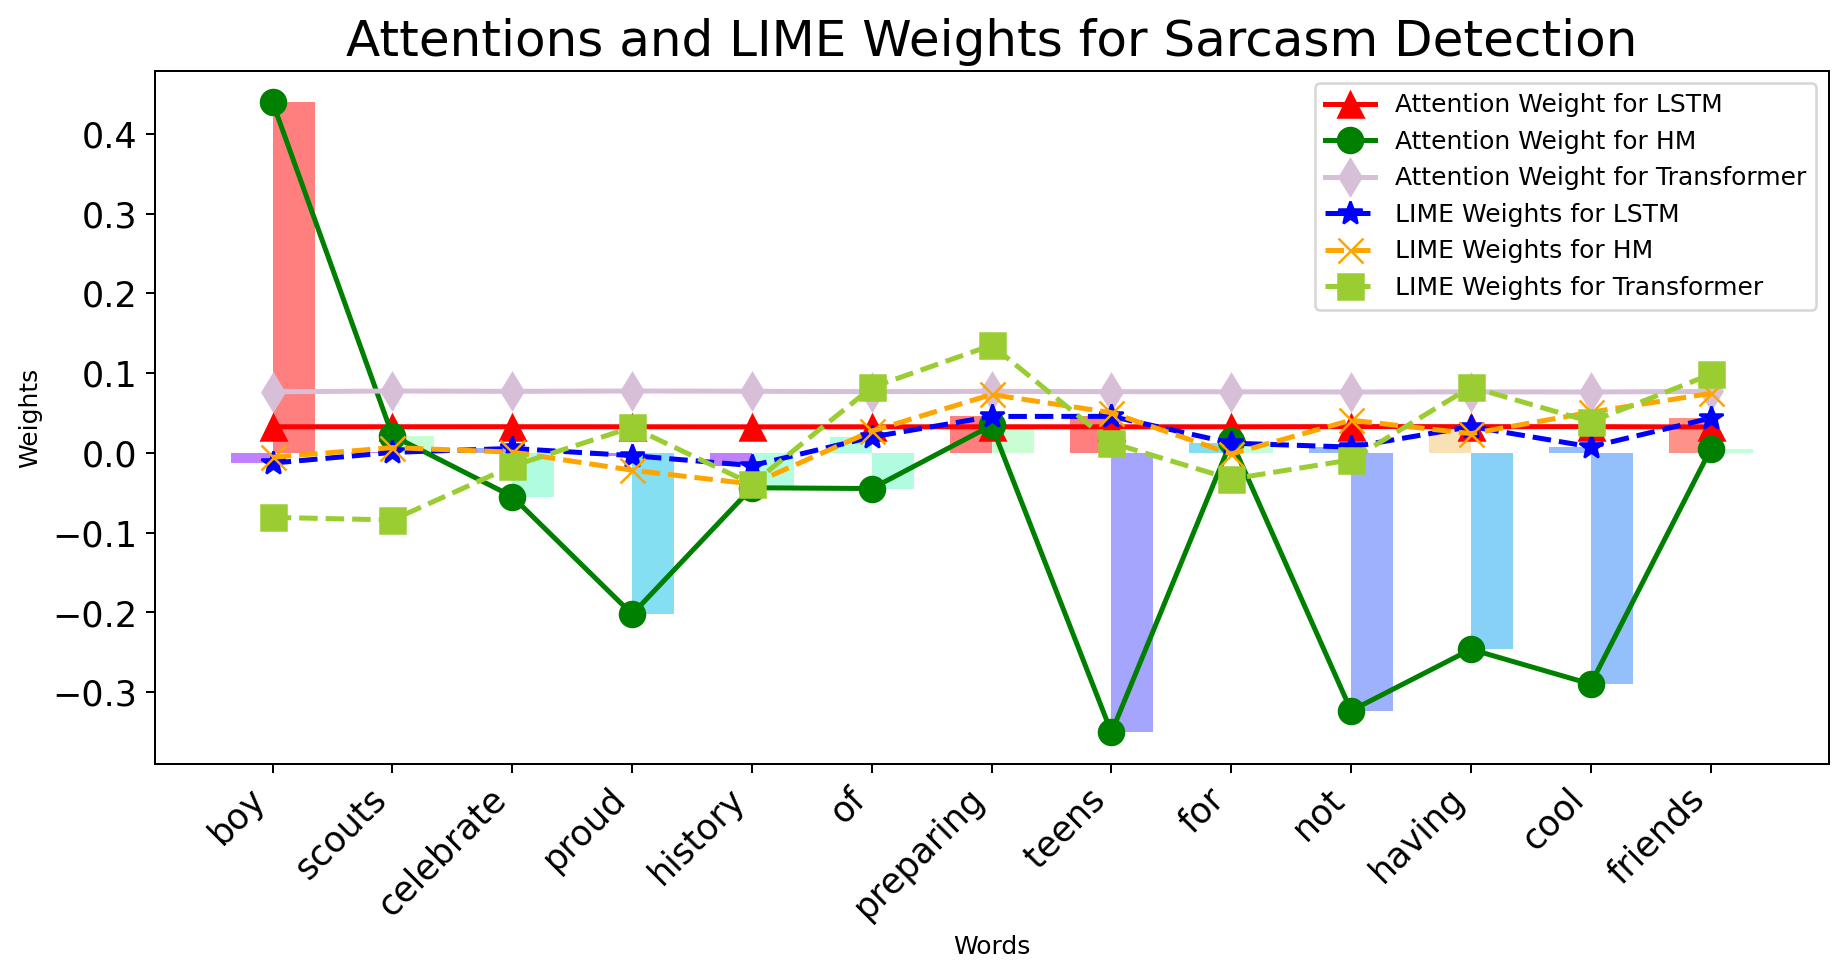

In [ ]:
plt.figure(figsize=(12, 5), dpi=180)

indices   = np.arange(len(words))
bar_width = 0.35
indices_lime = indices - bar_width/2
indices_att2 = indices + bar_width/2
# indices_att2 = indices + bar_width/3

plt.plot(indices, trimmed_att_weights_1, color='red',
         marker='^', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for LSTM')
plt.plot(indices, trimmed_att_weights_2, color='green',
         marker='o', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for HM')
plt.plot(indices, trimmed_att_weights_3, color='thistle',
         marker='d', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for Transformer')
plt.plot(indices, sorted_weights_1, color='blue',
         marker='*', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for LSTM')
plt.plot(indices, sorted_weights_2, color='orange',
         marker='x', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for HM')
plt.plot(indices, sorted_weights_3, color='yellowgreen',
         marker='s', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for Transformer')

plt.bar(indices_att2, trimmed_att_weights_2, bar_width, color=cols_att_2, alpha=.5)
plt.bar(indices_lime, sorted_weights_1, bar_width, color=cols_lime_1, alpha=.5)

plt.xticks(indices, words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title('Attentions and LIME Weights for Sarcasm Detection', size=20)
plt.legend()
plt.show()

## Plotting all 4 performance together
**with epoch would be ideal**

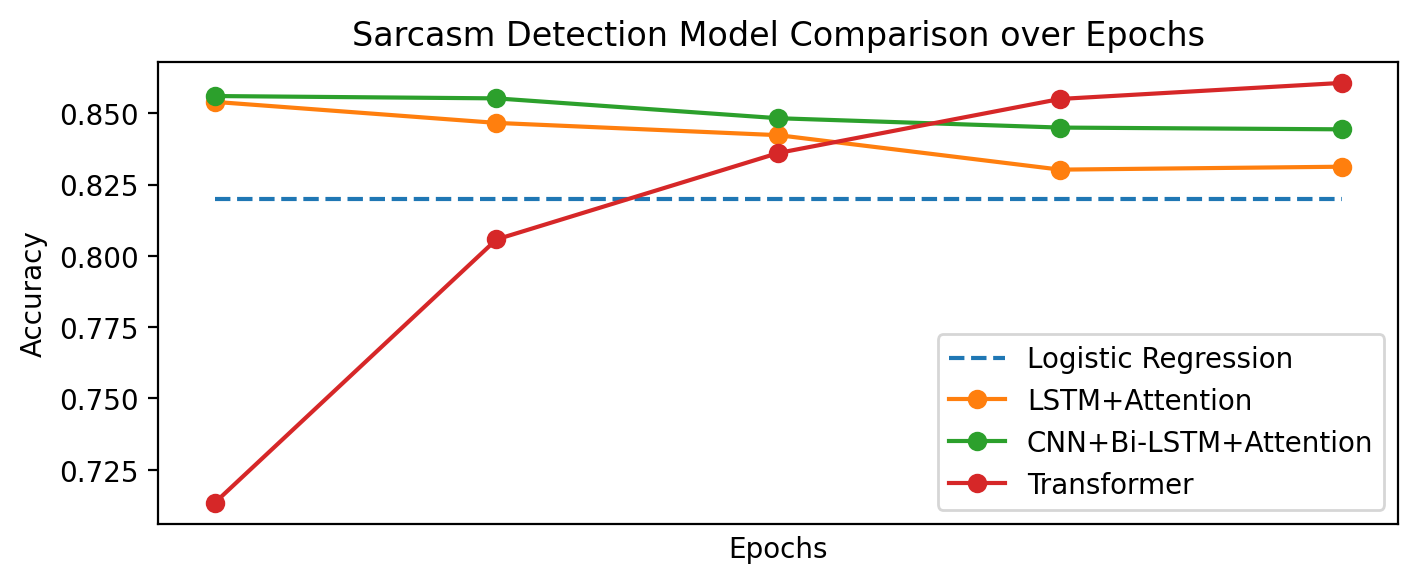

In [ ]:
# Example data (replace with your actual data)
epochs = [1, 2, 3, 4, 5]  # Assuming 5 epochs
accuracy_logistic = [0.82, 0.82, 0.82, 0.82, 0.82]
accuracy_lstm = history_2.history['val_dense_accuracy']
accuracy_cnn = history_3.history['val_accuracy']
accuracy_tran = epoch_val_accuracies

# Plotting
plt.figure(figsize=(8, 3), dpi=200)

plt.plot(epochs, accuracy_logistic, label='Logistic Regression', linestyle='--')
plt.plot(epochs, accuracy_lstm, label='LSTM+Attention', marker='o')
plt.plot(epochs, accuracy_cnn, label='CNN+Bi-LSTM+Attention', marker='o')
plt.plot(epochs, accuracy_tran, label='Transformer', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Sarcasm Detection Model Comparison over Epochs')
plt.legend()

# Remove x-axis ticks and grid
plt.xticks([])
plt.grid(False)

plt.show()